In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf
!pip install statsmodels==0.12.1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
fc-cache: invalid option -- ']'
usage: fc-cache [-EfrsvVh] [-y SYSROOT] [--error-on-no-fonts] [--force|--really-force] [--sysroot=SYSROOT] [--system-only] [--verbose] [--version] [--help] [dirs]
Build font information caches in [dirs]
(all directories in font configuration by default).

  -E, --error-on-no-fonts  raise an error if no fonts in a directory
  -f, --force              scan directories with apparently valid caches
  -r, --really-force       erase all existing caches, then rescan
  -s, --system-only        scan system-wide directories only
  -y, --sysroot=SYSROOT    prepend SYSROOT to all paths for scanning
  -v, --verbose            display status information while busy
  -V, --version            display font config version and exit
  -h, --help               di

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import tensorflow as tf
import keras
from numpy import array
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import json
import datetime
import os
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 데이터프레임

EDA와 기본 모델을 만들때 사용할 데이터프레임

train이랑 test를 합친 데이터프레임임

2016.1.1부터 2020.1.4까지 농산물 거래량이랑 가격으로 구성되어있음

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/nongsan_data/train.csv', encoding='utf-8')
test = pd.read_csv('/content/gdrive/MyDrive/nongsan_data/test_2020-11-05.csv', encoding='utf-8')
df = pd.concat([df,test], axis=0)
df.date = pd.to_datetime(df.date)
df = pd.concat([df, pd.get_dummies(df['요일'])], axis=1)
feature = df.columns[2:]
df = df.reset_index(drop=True)
df

date   요일  배추_거래량(kg)  배추_가격(원/kg)  ...  월요일  일요일  토요일  화요일
0    2016-01-01  금요일         0.0          0.0  ...    0    0    0    0
1    2016-01-02  토요일     80860.0        329.0  ...    0    0    1    0
2    2016-01-03  일요일         0.0          0.0  ...    0    1    0    0
3    2016-01-04  월요일   1422742.5        478.0  ...    1    0    0    0
4    2016-01-05  화요일   1167241.0        442.0  ...    0    0    0    1
...         ...  ...         ...          ...  ...  ...  ...  ...  ...
1765 2020-10-31  토요일   1472058.7        453.0  ...    0    0    1    0
1766 2020-11-01  일요일         0.0          0.0  ...    0    1    0    0
1767 2020-11-02  월요일   1792408.9        441.0  ...    1    0    0    0
1768 2020-11-03  화요일   2015926.5        478.0  ...    0    0    0    1
1769 2020-11-04  수요일   1884530.8        437.0  ...    0    0    0    0

[1770 rows x 51 columns]

# EDA

## 농산물 품목 별 가격

계절 패턴이 뚜렷하고 품목별로 확연히 다른 분포를 보임 -> 품목별 모델 생성, 시계열 반영 모델 생성

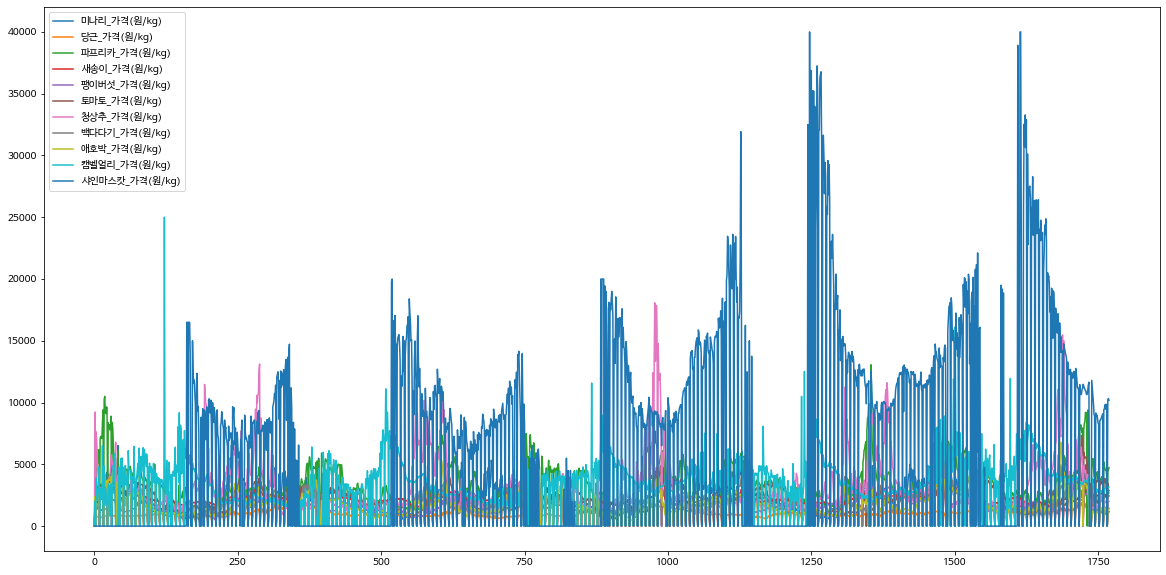

In [ ]:
feature_price = []
for i in range(1,22):
  feature_price.append(feature[2*i-1])
  
df[feature_price[10:]].plot(figsize=(20,10))

## 농산물 가격 분포

특이값이 많이 포함되어 있음 (이상치가 아니라 우리가 예측해야 하는 값)

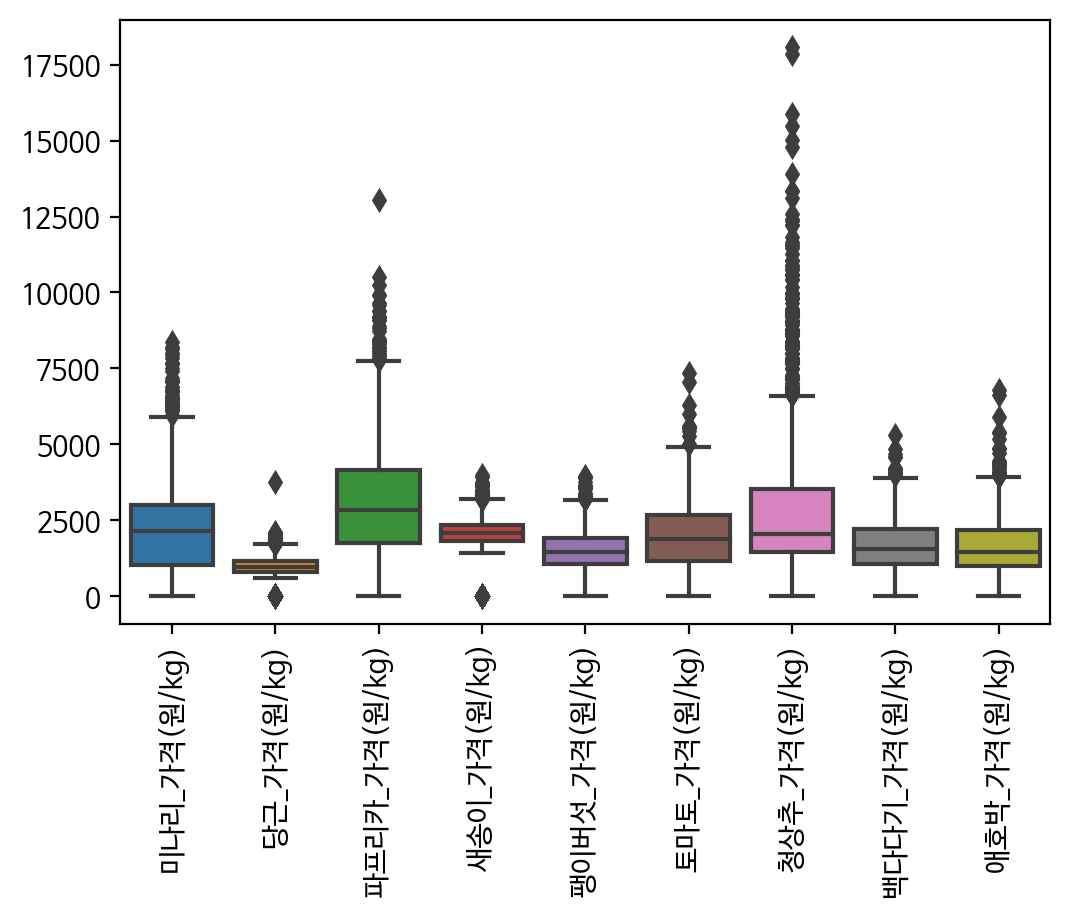

In [ ]:
fig = plt.figure(dpi=200)
plt.xticks(rotation=90)
sns.boxplot(data=df[feature_price[10:19]])

## 특이값 발생 원인
건고추의 경우 장마 기간이 길어지면 건조가 안돼서 가격 폭등 발생

특이값 예측 방안을 마련해야 할 필요가 있음

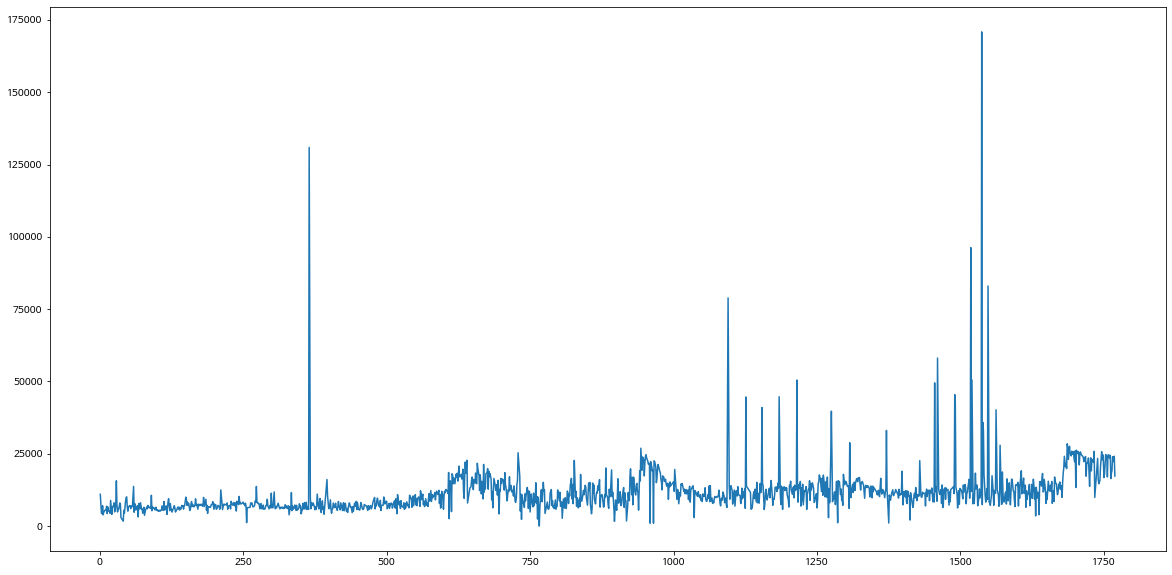

In [ ]:
df[df['건고추_가격(원/kg)'] > 1]['건고추_가격(원/kg)'].plot(figsize=(20,10))

# 모델링

## 첫번째 모델

대략적인 예측 성능을 알아보기 위한 모델

일주일 후 배추 가격을 예측

In [ ]:
df['target'] = df['배추_가격(원/kg)'].shift(-8)
df['target']

0       389.0
1         0.0
2       398.0
3       431.0
4       429.0
        ...  
1765      NaN
1766      NaN
1767      NaN
1768      NaN
1769      NaN
Name: target, Length: 1770, dtype: float64

In [ ]:
df_learn = df[df['target'].notnull()]
X = df_learn[feature]
y = df_learn['target']

## 첫번째 모델의 예측결과

전반적인 추세는 잘 예측하지만 거래가 발생하지 않는 일요일 전후로 예측 성능이 떨어지는 모습을 보임

큰 폭으로 변동되는 가격은 잘 예측 하지 못함(뾰족뾰족한 부분)

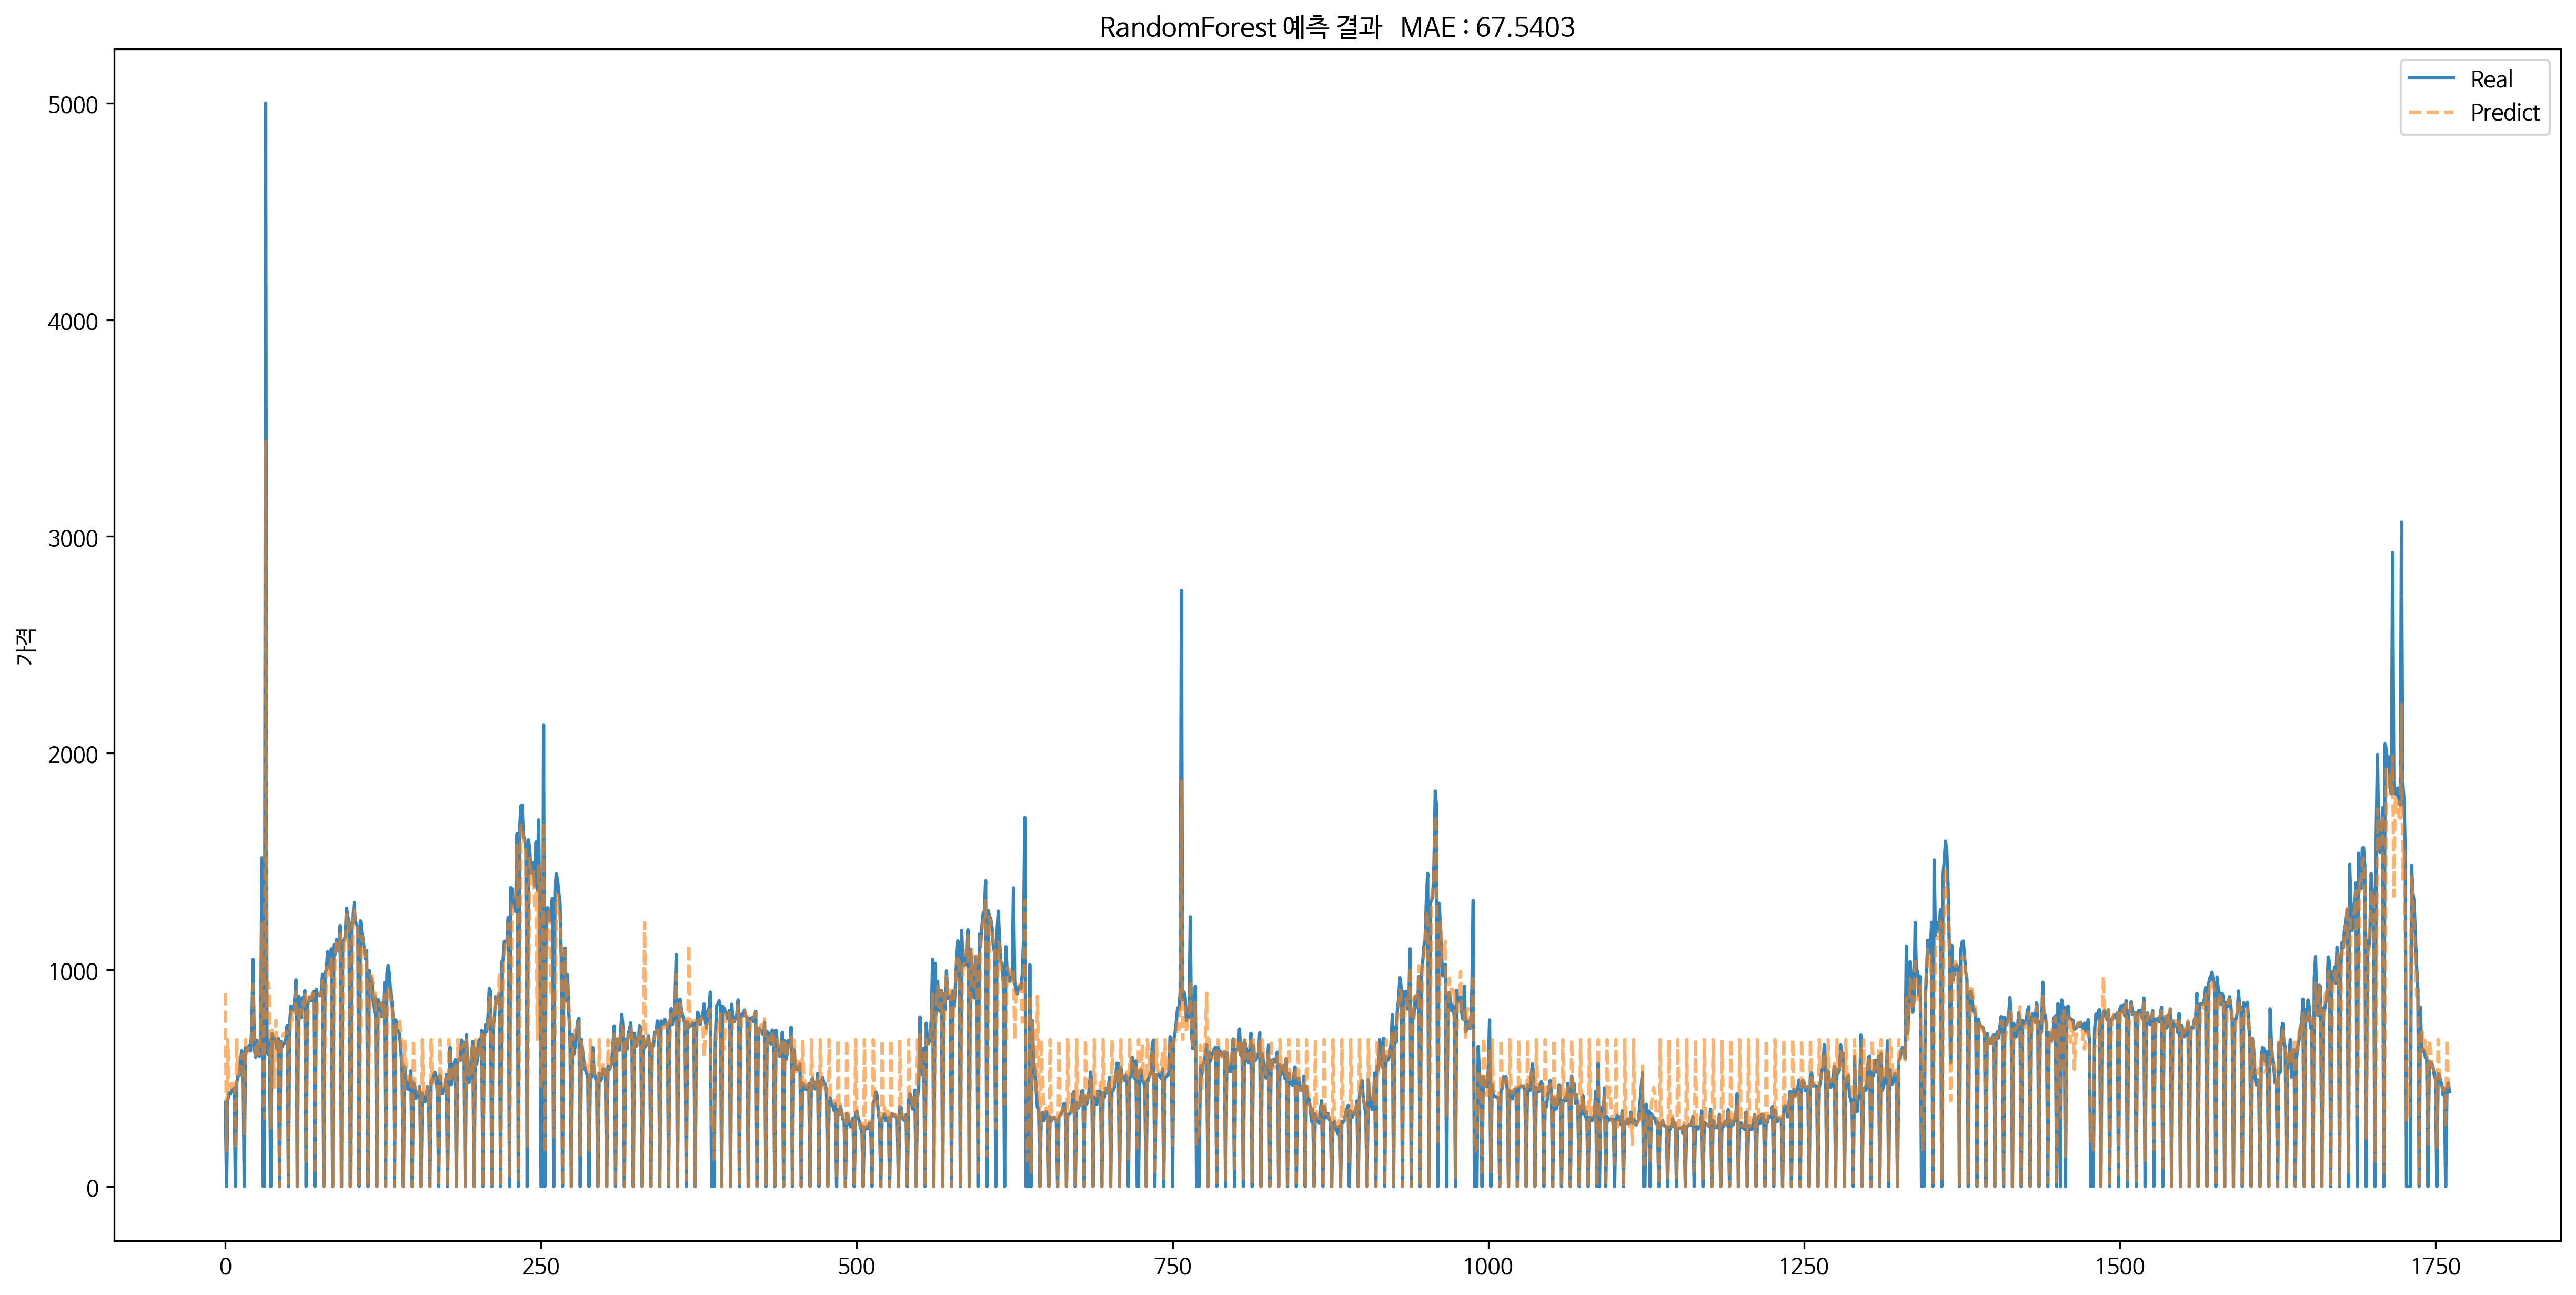

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=123)

with tf.device('/device:GPU:0'):
  model = RandomForestRegressor()
  model.fit(X, y)

y_pred = model.predict(X)
# R2 = model.score(X_train, y_train)
MAE = mean_absolute_error(y, y_pred)

plt.figure(figsize=(20, 10), dpi=300)
plt.title('RandomForest 예측 결과'+   '   MAE : ' + str(MAE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

# feature
농산물 가격은 비정상 시계열 데이터

거래량은 정상성을 띄는 시계열 데이터

상관분석 -> 거래량은 가격이랑 큰 상관이 없음

거래량은 feature에서 제외

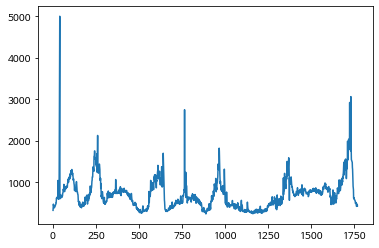

In [ ]:
df[df['배추_가격(원/kg)'] > 1]['배추_가격(원/kg)'].plot()

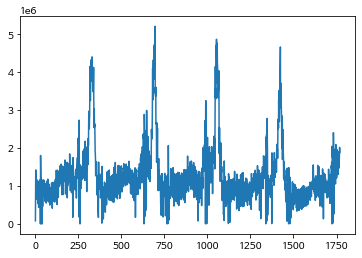

In [ ]:
df[df['배추_거래량(kg)'] > 1]['배추_거래량(kg)'].plot()

In [ ]:
corr = df[['배추_가격(원/kg)', '배추_거래량(kg)']]
corr = corr.corr(method = 'pearson')

             배추_가격(원/kg)  배추_거래량(kg)
배추_가격(원/kg)     1.000000    0.258247
배추_거래량(kg)      0.258247    1.000000


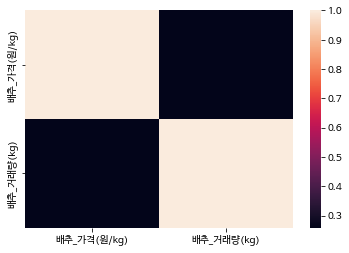

In [ ]:
sns.heatmap(corr)
print(corr)

## feature로 거래량 제외하고 가격만 활용해서 예측한 모델

In [ ]:
df.columns

Index(['date', '요일', '배추_거래량(kg)', '배추_가격(원/kg)', '무_거래량(kg)', '무_가격(원/kg)',
       '양파_거래량(kg)', '양파_가격(원/kg)', '건고추_거래량(kg)', '건고추_가격(원/kg)',
       '마늘_거래량(kg)', '마늘_가격(원/kg)', '대파_거래량(kg)', '대파_가격(원/kg)',
       '얼갈이배추_거래량(kg)', '얼갈이배추_가격(원/kg)', '양배추_거래량(kg)', '양배추_가격(원/kg)',
       '깻잎_거래량(kg)', '깻잎_가격(원/kg)', '시금치_거래량(kg)', '시금치_가격(원/kg)',
       '미나리_거래량(kg)', '미나리_가격(원/kg)', '당근_거래량(kg)', '당근_가격(원/kg)',
       '파프리카_거래량(kg)', '파프리카_가격(원/kg)', '새송이_거래량(kg)', '새송이_가격(원/kg)',
       '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)',
       '청상추_거래량(kg)', '청상추_가격(원/kg)', '백다다기_거래량(kg)', '백다다기_가격(원/kg)',
       '애호박_거래량(kg)', '애호박_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',
       '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)', '금요일', '목요일', '수요일', '월요일', '일요일',
       '토요일', '화요일', 'target'],
      dtype='object')

In [ ]:
feature = ['배추_가격(원/kg)', '무_가격(원/kg)', '양파_가격(원/kg)', '건고추_가격(원/kg)', '마늘_가격(원/kg)', '대파_가격(원/kg)', '얼갈이배추_가격(원/kg)', '양배추_가격(원/kg)',
       '깻잎_가격(원/kg)', '시금치_가격(원/kg)', '미나리_가격(원/kg)', '당근_가격(원/kg)', '파프리카_가격(원/kg)', '새송이_가격(원/kg)', '팽이버섯_가격(원/kg)', '토마토_가격(원/kg)',
       '청상추_가격(원/kg)', '백다다기_가격(원/kg)', '애호박_가격(원/kg)', '캠벨얼리_가격(원/kg)', '샤인마스캇_가격(원/kg)']

In [ ]:
df['target'] = df['배추_가격(원/kg)'].shift(-8)
df['target']

0       389.0
1         0.0
2       398.0
3       431.0
4       429.0
        ...  
1765      NaN
1766      NaN
1767      NaN
1768      NaN
1769      NaN
Name: target, Length: 1770, dtype: float64

In [ ]:
df_learn = df[df['target'].notnull()]
X = df_learn[feature]
y = df_learn['target']

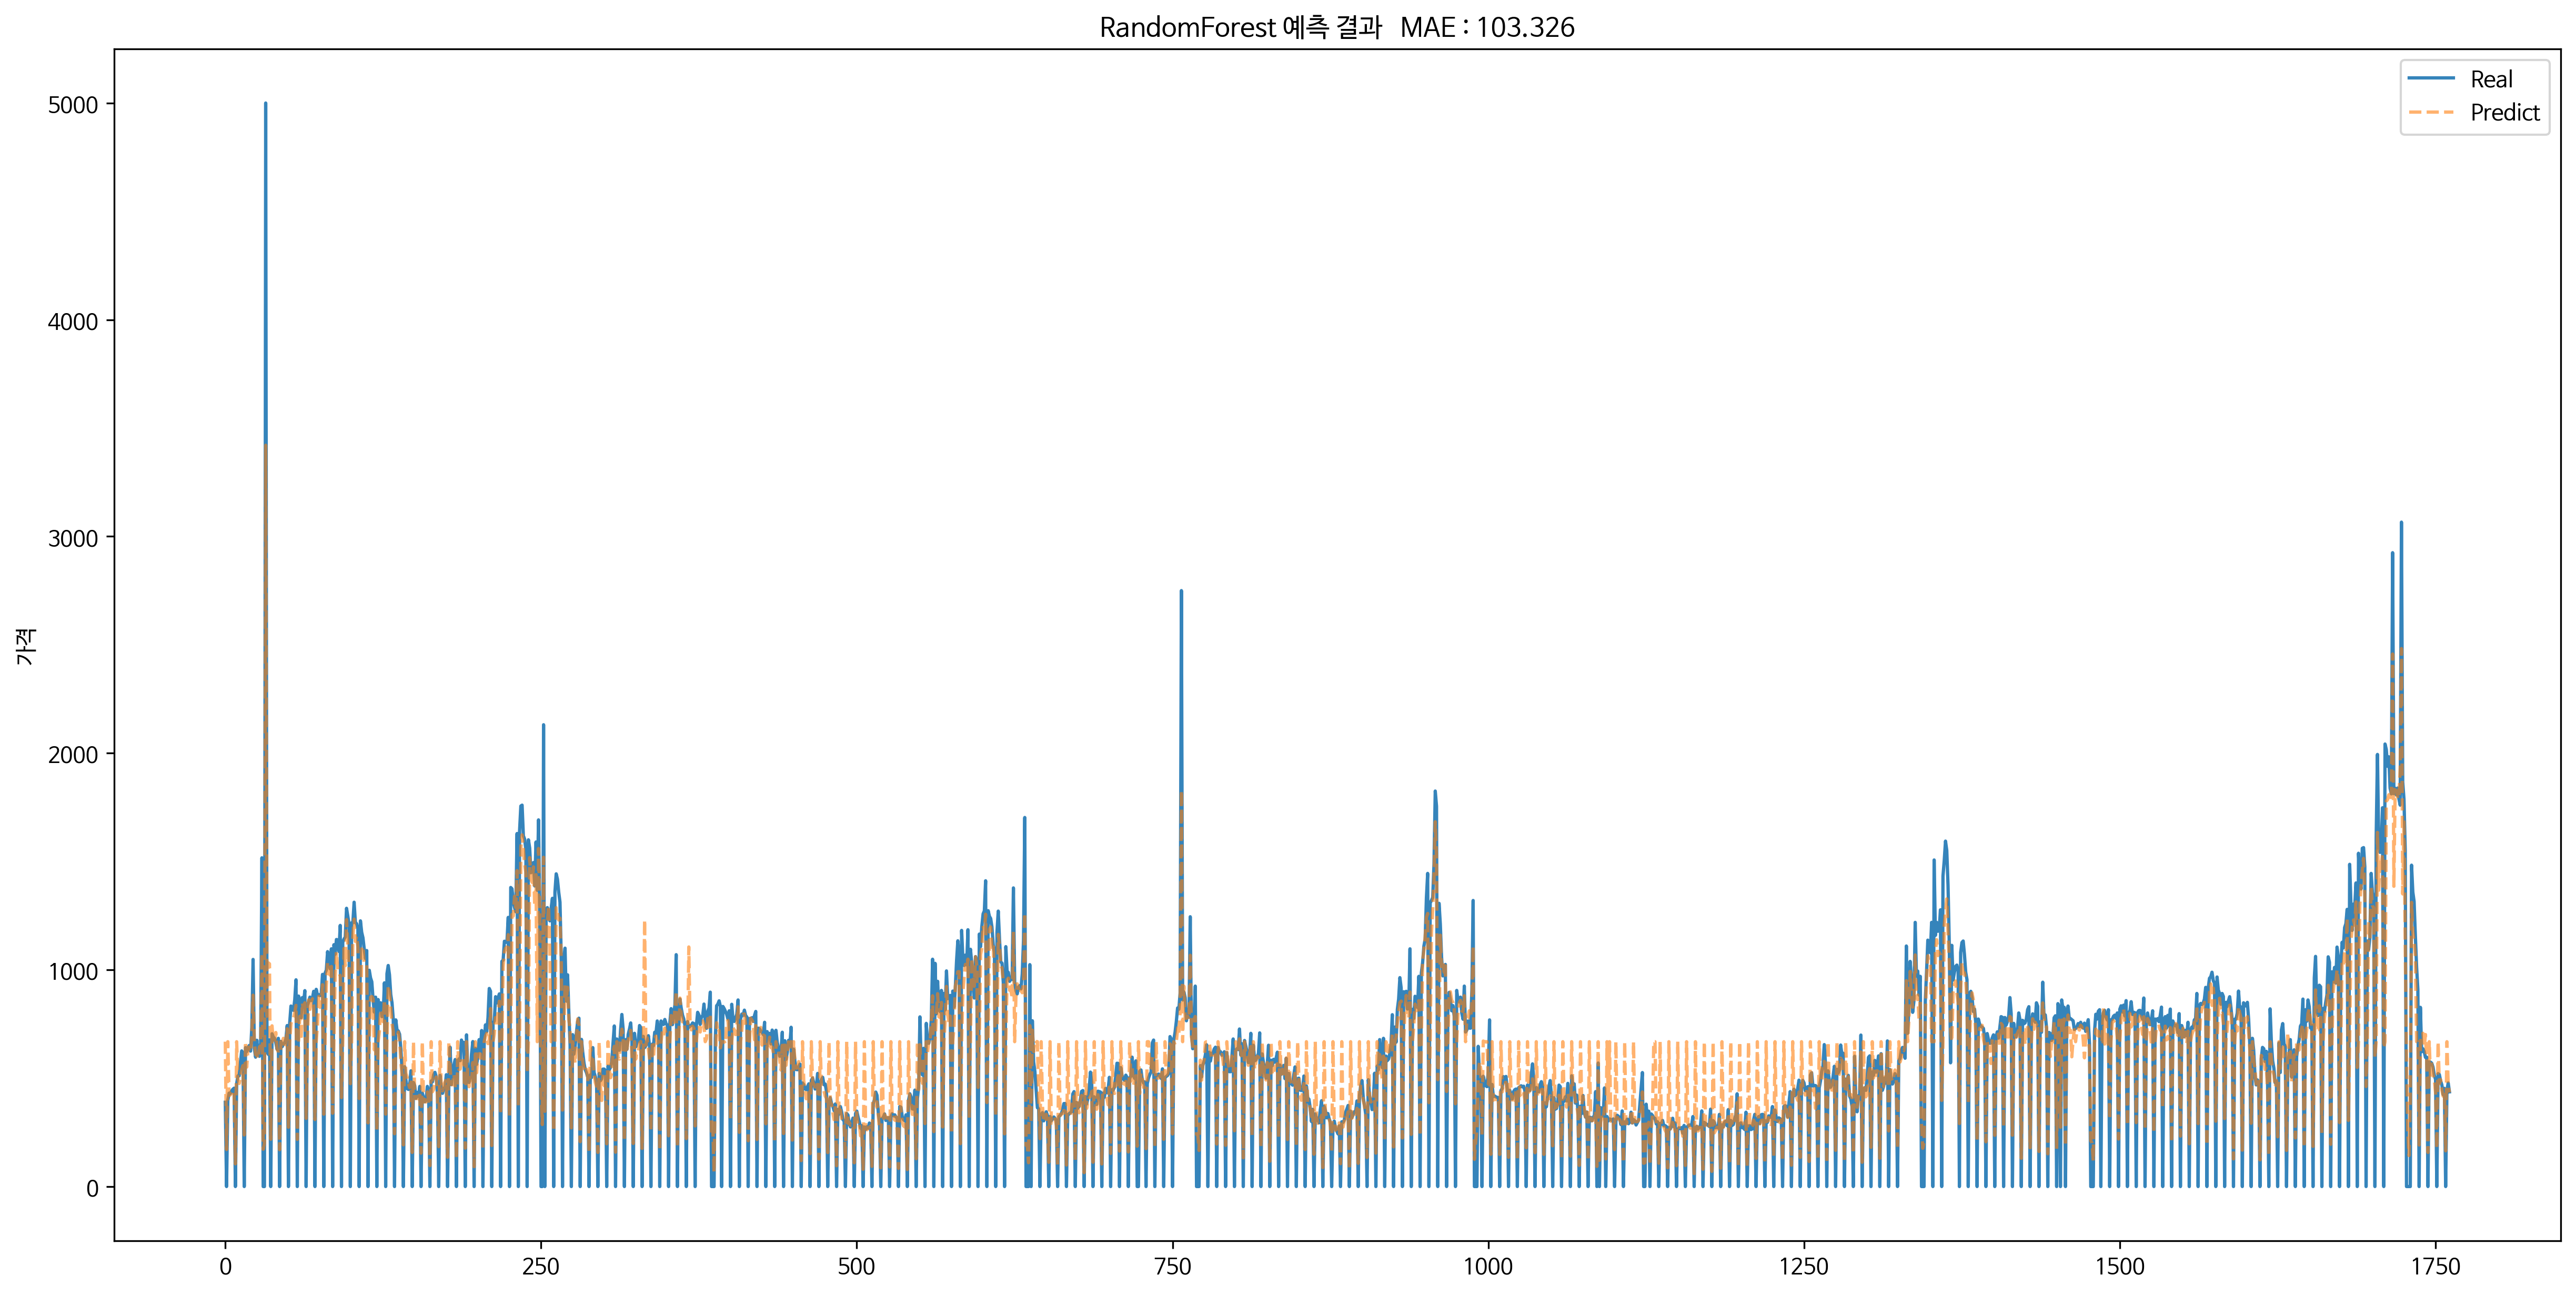

In [ ]:
with tf.device('/device:GPU:0'):
  model = RandomForestRegressor()
  model.fit(X, y)

y_pred = model.predict(X)
# R2 = model.score(X_train, y_train)
MAE = mean_absolute_error(y, y_pred)

plt.figure(figsize=(20, 10), dpi=300)
plt.title('RandomForest 예측 결과'+   '   MAE : ' + str(MAE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

## 일요일 제외

거래가 발생하지 않은 날의 농산물 가격을 하루전, 하루후 가격의 평균으로 대체

In [ ]:
df = df[1:].replace(0, np.NaN)
df = df.interpolate().fillna(0)
df[:10]

date   요일  배추_거래량(kg)  배추_가격(원/kg)  ...  일요일  토요일  화요일  target
1  2016-01-02  토요일    80860.00        329.0  ...  0.0  1.0  0.0     0.0
2  2016-01-03  일요일   751801.25        403.5  ...  1.0  1.0  0.0   398.0
3  2016-01-04  월요일  1422742.50        478.0  ...  1.0  1.0  0.0   431.0
4  2016-01-05  화요일  1167241.00        442.0  ...  1.0  1.0  1.0   429.0
5  2016-01-06  수요일  1045507.50        442.0  ...  1.0  1.0  1.0   441.0
6  2016-01-07  목요일  1039925.00        448.0  ...  1.0  1.0  1.0   449.0
7  2016-01-08  금요일   942655.00        420.0  ...  1.0  1.0  1.0   454.0
8  2016-01-09  토요일   689121.00        389.0  ...  1.0  1.0  1.0   464.5
9  2016-01-10  일요일   925074.50        393.5  ...  1.0  1.0  1.0   475.0
10 2016-01-11  월요일  1161028.00        398.0  ...  1.0  1.0  1.0   511.0

[10 rows x 52 columns]

In [ ]:
df_learn = df[df['target'].notnull()]
X = df_learn[feature]
y = df_learn['target']

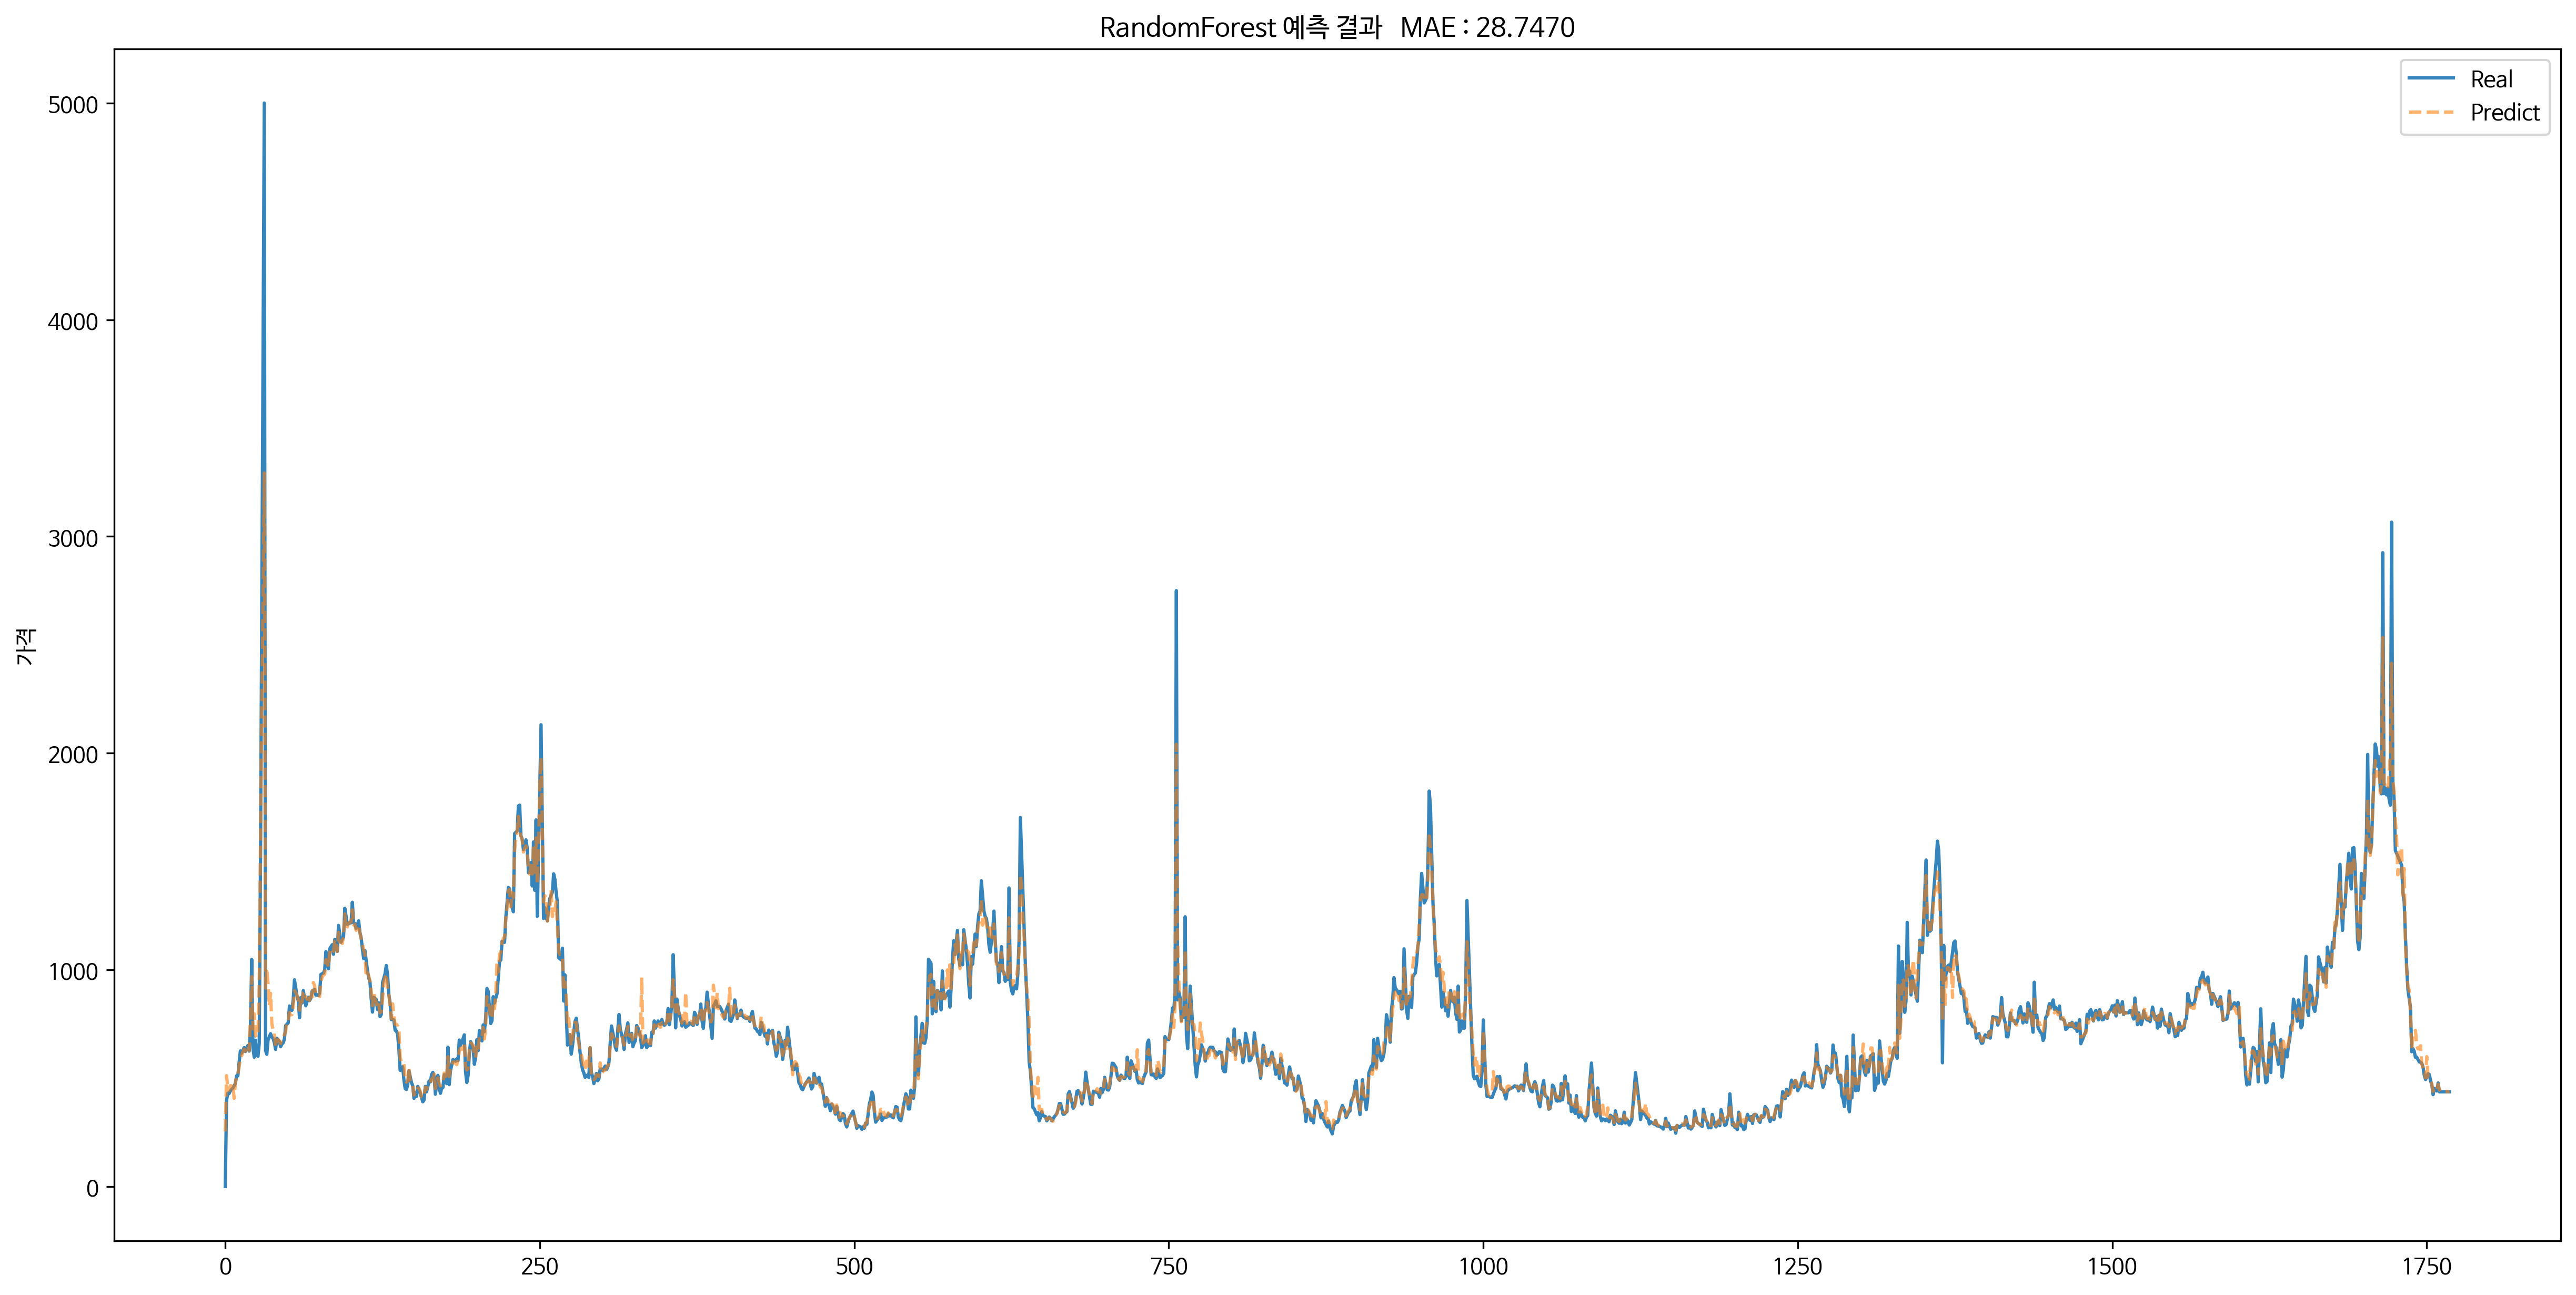

In [ ]:
with tf.device('/device:GPU:0'):
  model = RandomForestRegressor()
  model.fit(X, y)

y_pred = model.predict(X)
# R2 = model.score(X_train, y_train)
MAE = mean_absolute_error(y, y_pred)

plt.figure(figsize=(20, 10), dpi=300)
plt.title('RandomForest 예측 결과'+   '   MAE : ' + str(MAE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

## 시계열 분해

분해 시계열의 잔차를 feature로 활용

In [ ]:
df['resid'] = 0
stl = STL(df[['date', '배추_가격(원/kg)']].set_index('date'), period=12)
res = stl.fit()
df['resid'] = res.resid.values

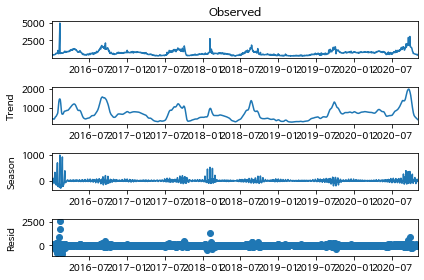

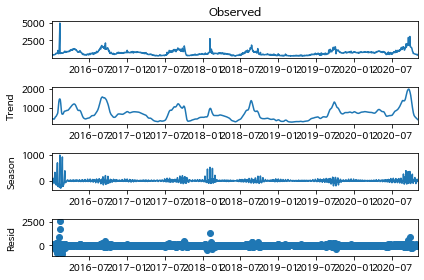

In [ ]:
res.plot()

## 분해 시계열의 잔차를 feature로 활용한 랜덤포레스트 모델

In [ ]:
df.head()

date   요일  배추_거래량(kg)  배추_가격(원/kg)  ...  토요일  화요일  target       resid
1 2016-01-02  토요일    80860.00        329.0  ...  1.0  0.0     0.0  -85.471205
2 2016-01-03  일요일   751801.25        403.5  ...  1.0  0.0   398.0   -1.189226
3 2016-01-04  월요일  1422742.50        478.0  ...  1.0  0.0   431.0   81.571633
4 2016-01-05  화요일  1167241.00        442.0  ...  1.0  1.0   429.0  128.658480
5 2016-01-06  수요일  1045507.50        442.0  ...  1.0  1.0   441.0  -45.363387

[5 rows x 53 columns]

In [ ]:
feature = feature + ['resid']

In [ ]:
df_learn = df[df['target'].notnull()]
X = df_learn[feature]
y = df_learn['target']

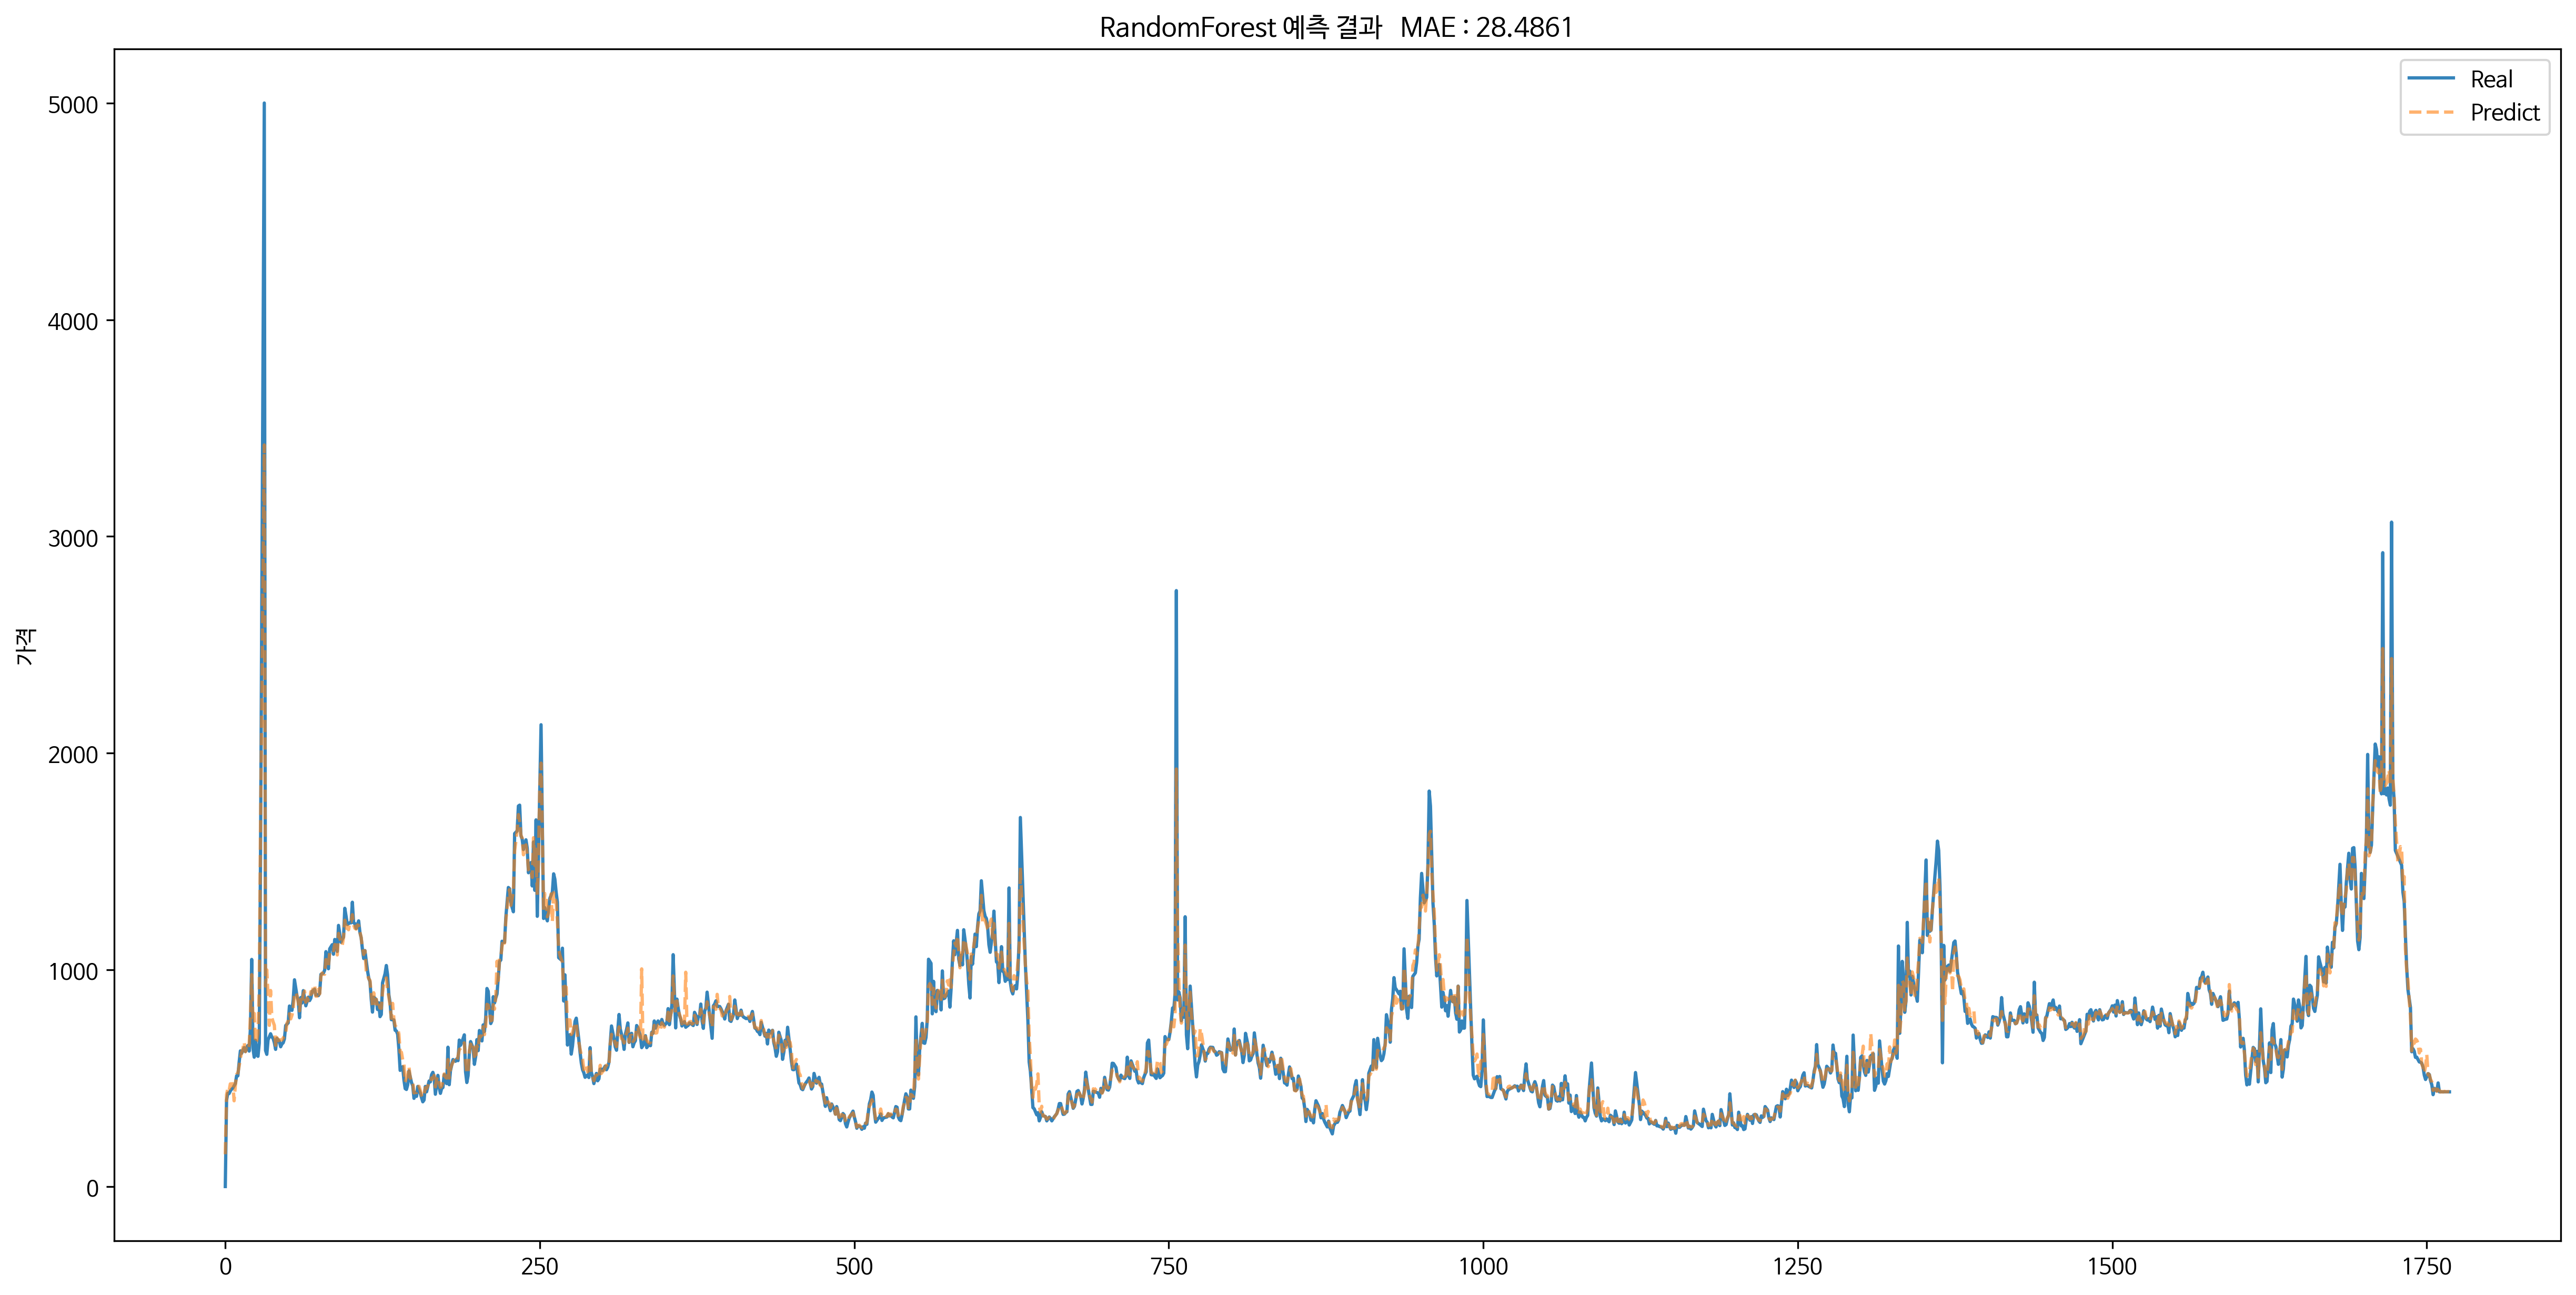

In [ ]:
with tf.device('/device:GPU:0'):
  model = RandomForestRegressor()
  model.fit(X, y)

y_pred = model.predict(X)
# R2 = model.score(X_train, y_train)
MAE = mean_absolute_error(y, y_pred)

plt.figure(figsize=(20, 10), dpi=300)
plt.title('RandomForest 예측 결과'+   '   MAE : ' + str(MAE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

# 모델선정

## 모델 성능 평가

랜덤포레스트 모델은 미래를 잘 예측하지는 못함

train과 test를 구분해서 test셋을 잘 예측하는지 보기 위함

4주 후 예측

In [ ]:
df['target'] = df['배추_가격(원/kg)'].shift(-29)
df_learn = df[:-58]
df_predict = df[-58:]
train_X = df_learn[feature]
train_y = df_learn['target']
test_X = df_predict[:29][feature]
test_y = df_predict[:29]['target']

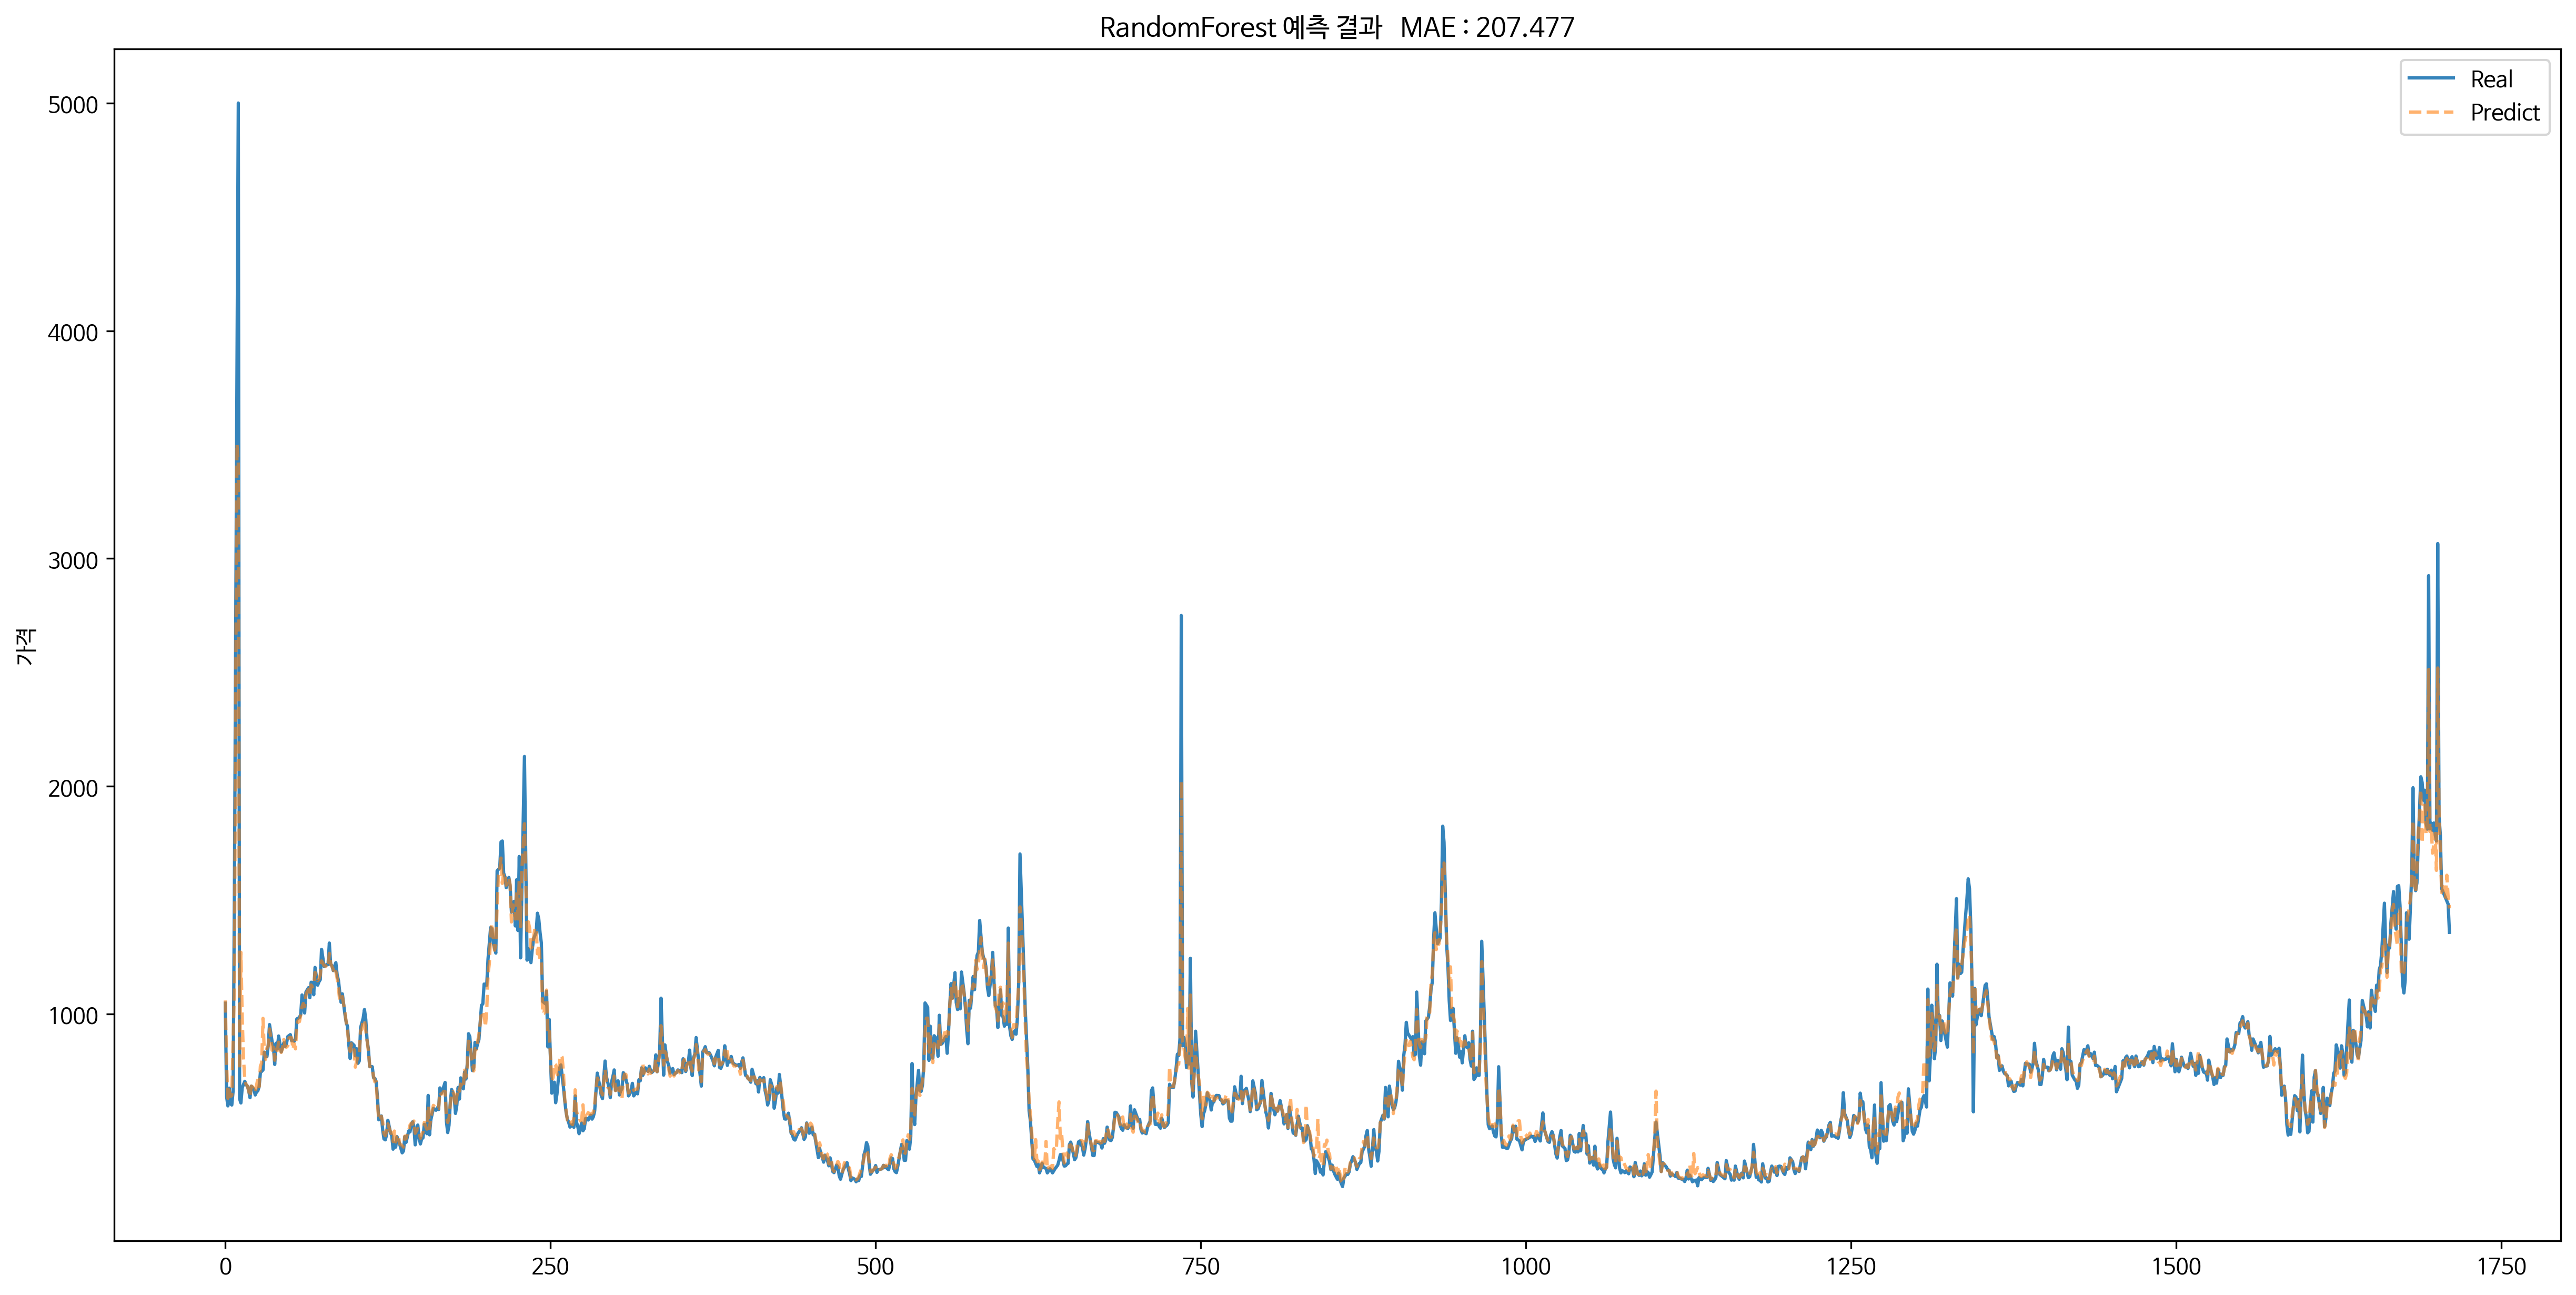

In [ ]:
with tf.device('/device:GPU:0'):
  model = RandomForestRegressor()
  model.fit(train_X, train_y)

y_pred = model.predict(test_X)
# R2 = model.score(X_train, y_train)
MAE = mean_absolute_error(test_y, y_pred)

plt.figure(figsize=(20, 10), dpi=300)
plt.title('RandomForest 예측 결과'+   '   MAE : ' + str(MAE)[:7])
plt.ylabel('가격')
plt.plot(np.array(train_y), alpha = 0.9, label = 'Real')
plt.plot(model.predict(train_X), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

## 앞으로 해야 되는거

랜덤포레스트를 썼는데 미래를 잘 예측하지는 못해서
lstm을 썼고 lstm은 feature로 자기 자신의 가격만 썼다

시계열을 반영하기 위해 lstm 모델을 썼고
feature selection 기능이 없는 lstm의 특성을 고려하여

예측하고자 하는 target feature만 feature로 활용

In [ ]:
df['target'] = df['배추_가격(원/kg)'].shift(-8)

feature = ['배추_거래량(kg)', '배추_가격(원/kg)', '금요일',   '목요일',   '수요일',   '월요일',   '일요일',   '토요일',   '화요일', 'resid']

scaler = MinMaxScaler()
df[feature] = scaler.fit_transform(df[feature])

df_learn = df[:-16]
df_predict = df[-16:]
train_X = df_learn[feature].values.reshape(-1,1,len(feature))
train_y = df_learn['target'].values.reshape(-1,1,1)
test_X = df_predict[:8][feature].values.reshape(-1,1,len(feature))
test_y = df_predict[:8]['target'].values.reshape(-1,1,1)

In [ ]:
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(layers.Activation('relu'))
  # CuDNNLSTM: Dropout 0.1, Dense 30
  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(100, input_shape=(21,len(feature)), return_sequences=True))
  model.add(Dropout(0.1))
  model.add(layers.Dense(30))
  model.add(Dropout(0.1))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam', loss='mse')
  early_stopping = EarlyStopping(patience=30)
  model.fit(train_X, train_y, epochs=1000, batch_size=32, validation_split = 0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/1000
50/50 [==============================] - 4s 10ms/step - loss: 560118.0000 - val_loss: 1244986.0000
Epoch 2/1000
50/50 [==============================] - 0s 5ms/step - loss: 527089.3125 - val_loss: 1143616.8750
Epoch 3/1000
50/50 [==============================] - 0s 5ms/step - loss: 429141.3750 - val_loss: 939257.6250
Epoch 4/1000
50/50 [==============================] - 0s 5ms/step - loss: 301269.8438 - val_loss: 720485.0000
Epoch 5/1000
50/50 [==============================] - 0s 4ms/step - loss: 199101.2188 - val_loss: 546929.8750
Epoch 6/1000
50/50 [==============================] - 0s 5ms/step - loss: 141832.0781 - val_loss: 437821.3750
Epoch 7/1000
50/50 [==============================] - 0s 5ms/step - loss: 119073.5391 - val_loss: 381316.9062
Epoch 8/1000
50/50 [==============================] - 0s 4ms/step - loss: 115273.8828 - val_loss: 354602.3438
Epoch 9/1000
50/50 [==============================] - 0s 4ms/step - loss: 111121.6094 - val_loss: 347502.0625
Epoch 1

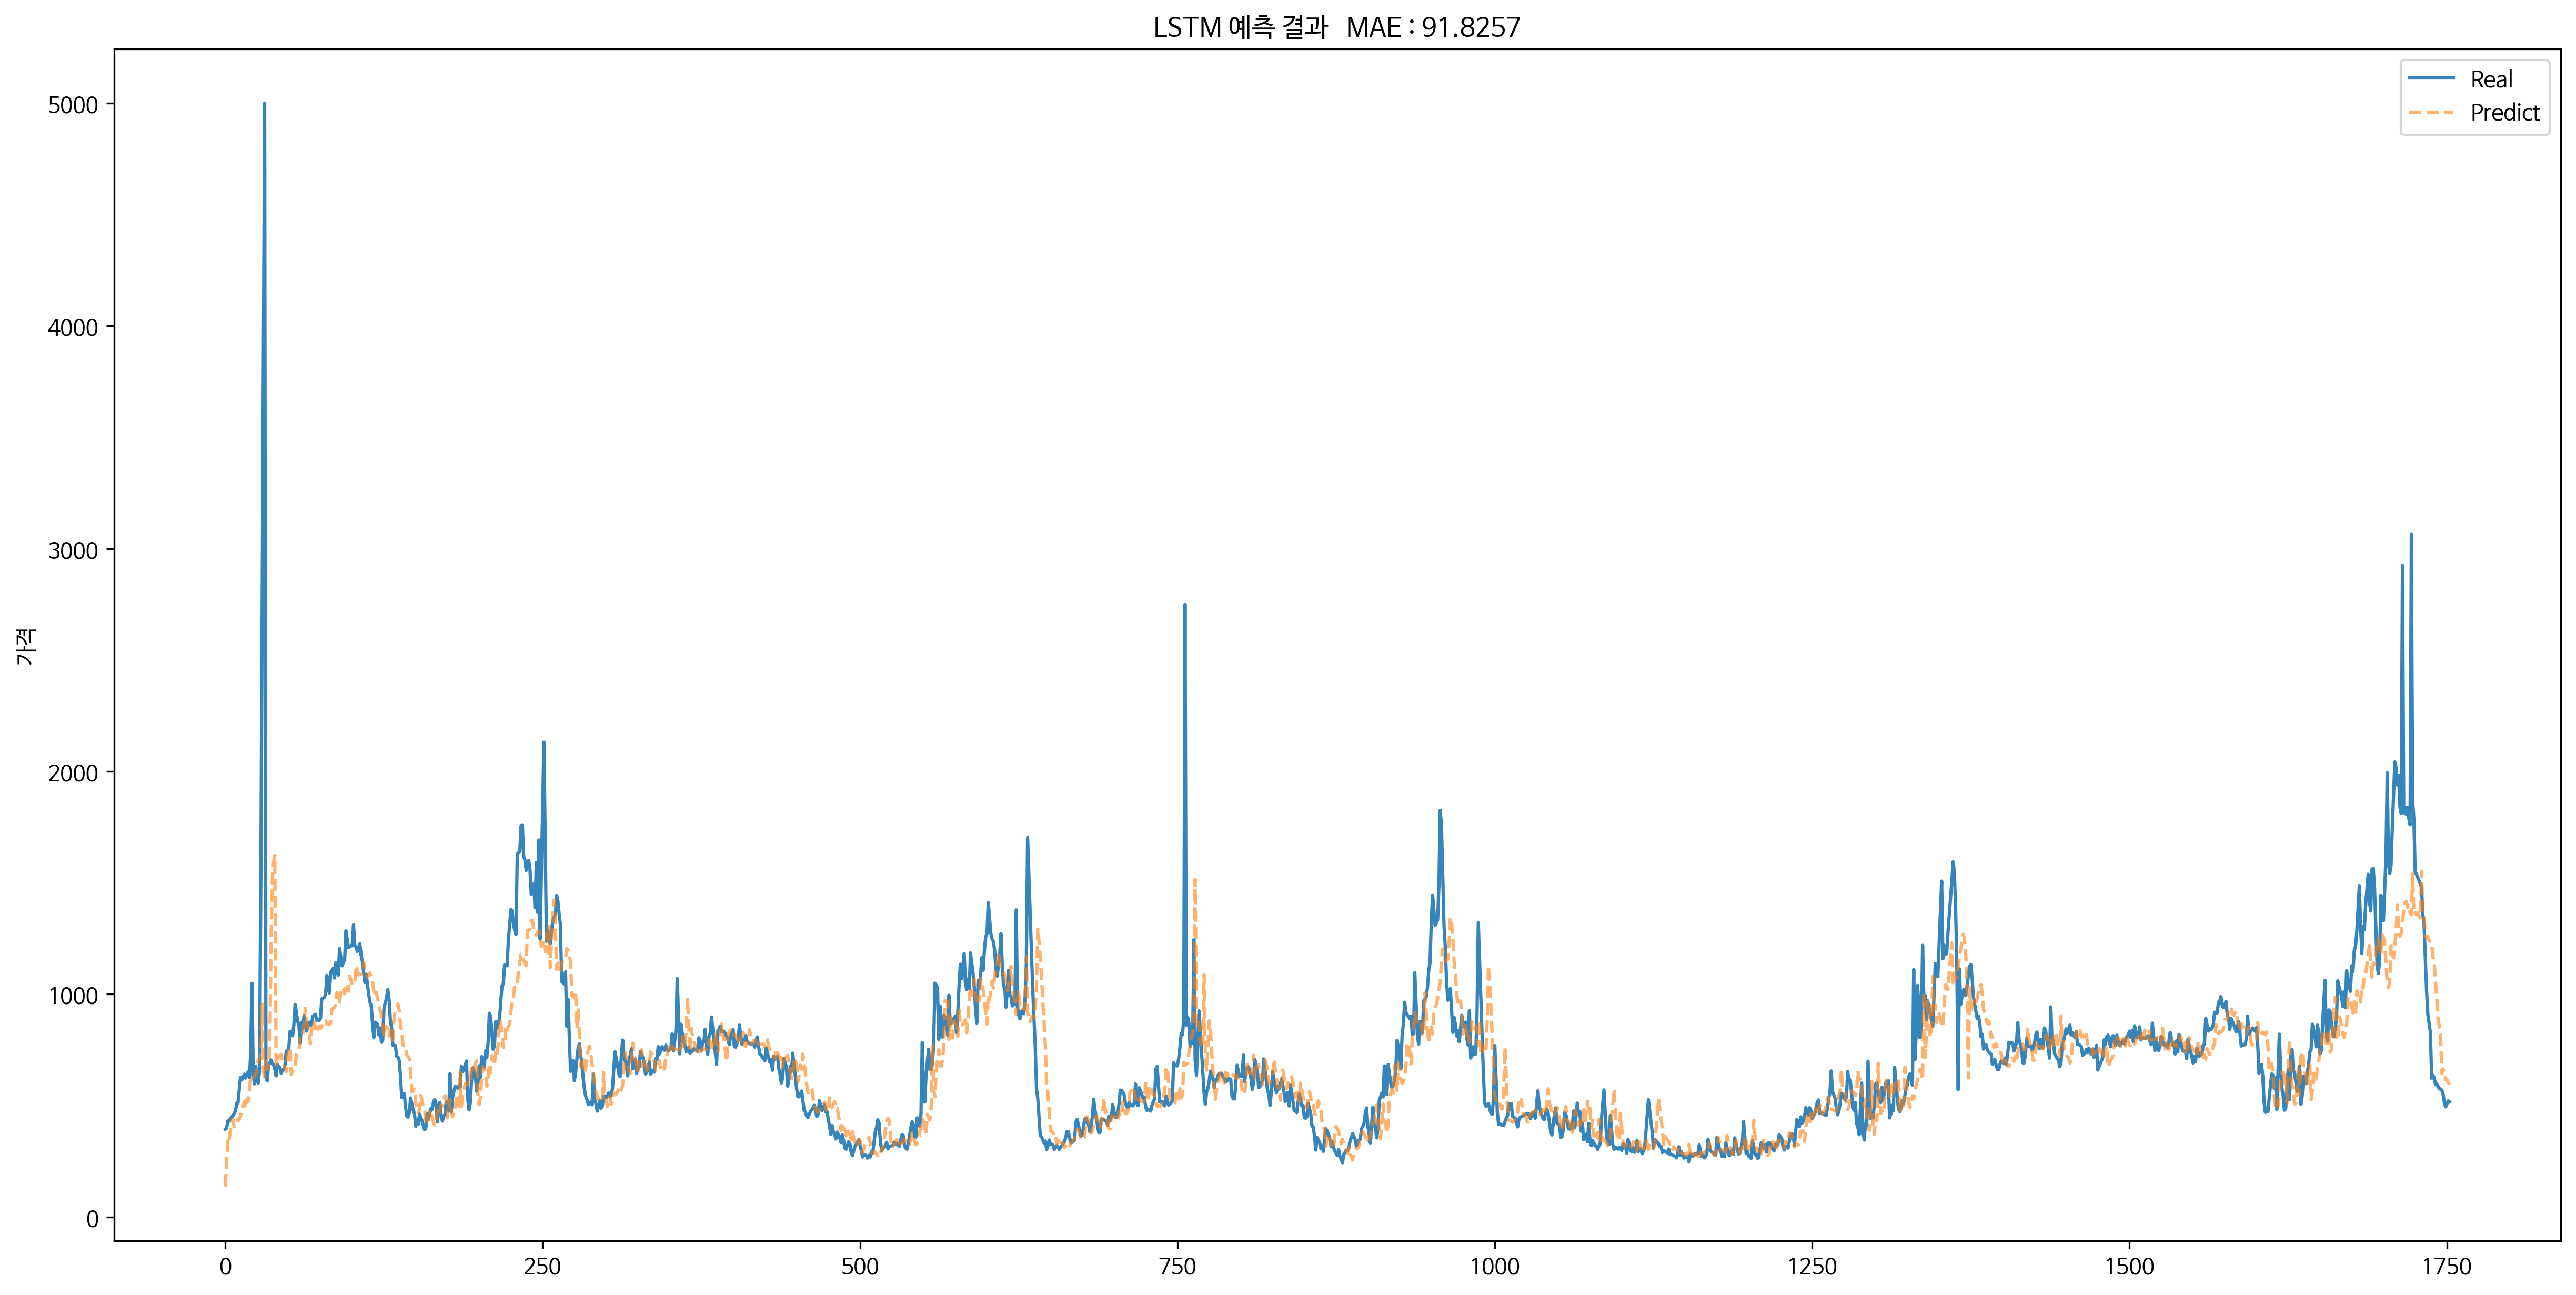

In [ ]:
y_pred = model.predict(test_X)
# R2 = model.score(X_train, y_train)
MAE = mean_absolute_error(test_y.reshape(-1,1), y_pred.reshape(-1,1))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('LSTM 예측 결과'+   '   MAE : ' + str(MAE)[:7])
plt.ylabel('가격')
plt.plot(np.array(train_y.reshape(-1,1)), alpha = 0.9, label = 'Real')
plt.plot(model.predict(train_X).reshape(-1,1), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

## 해당 모델을 최종 모델로 선정

해당 모델의 원활한 사용을 위해 클래스로 모델을 정의

with tf.device('/device:GPU:0'):

안에 있는 모델링 관련 내용을 언급해야 함 :

- 시계열성을 반영하기 위해 LSTM 모델을 사용했고 과거 21일의 데이터로 미래를 예측하는 모델

- 오버피팅을 방지하기 위해 dropout 기법을 사용했고 비율은 10%

- 오버피팅을 방지하기 위해 전체 데이터 중 10%를 validation set으로 이용하여
earlystop 기법을 사용했음



In [ ]:
class Nong1:

  def __init__(self, df, test):
    # df: 제출일 기준 2일 전 농산물 거래 데이터
    self.df = df
    # test: 제출일 기준 1일 전 농산물 거래 데이터
    self.test = test
    # 제출일 기준 1일 전까지의 모든 데이터를 병합
    self.df = pd.concat([self.df, self.test], axis=0)
    # 병합한 데이터 프레임에서 0의 값을 갖는 데이터를 null값으로 처리
    self.df = self.df[1:].replace(0, np.NaN)
    self.df = self.df.interpolate().fillna(0)
    # date 열을 Datetime 으로 변환
    self.df.date = pd.to_datetime(self.df.date)
    # 요일을 원핫인코딩
    self.df = pd.concat([self.df, pd.get_dummies(self.df['요일'])], axis=1)
    # '배추_거래량(kg)'부터 feature로 선택
    self.feature = self.df.columns[2:]
    # 행 인덱스 초기화
    self.df = self.df.reset_index(drop=True)

  def set_feature(self,name):
    # target의 feature를 설정
    self.name = name
    self.name1 = name+"_가격(원/kg)"
    self.name2 = name+"_거래량(kg)"
    self.feature = [self.name1, self.name2, '금요일',   '목요일',   '수요일',   '월요일',   '일요일',   '토요일',   '화요일', 'resid']

  def set_target(self,week):
    # 1주 후, 2주 후, 4주 후를 예측하기 위해 target으로 설정
    if week == 1:
      self.df['target'] = self.df[self.name1].shift(-8)
    elif week == 2:
      self.df['target'] = self.df[self.name1].shift(-15)
    elif week == 4:
      self.df['target'] = self.df[self.name1].shift(-29)
      
    # 분해 시계열의 잔차  
    self.df['resid'] = 0
    stl = STL(self.df[['date', self.name1]].set_index('date'), period=12)
    res = stl.fit()
    self.df['resid'] = res.resid.values

  def set_model(self):
    # 이상치가 아니라 특이값이라 판단, 분포 왜곡을 막기 위해 MinMax스케일링
    self.scaler = MinMaxScaler()
    self.df[self.feature] = self.scaler.fit_transform(self.df[self.feature])
    # 학습데이터 프레임 선언
    self.df_learn = self.df[self.df['target'].notnull()]
    # LSTM에 맞게 X,y값의 shape 변경
    self.X = self.df_learn[self.feature].values.reshape(-1,1,len(self.feature))
    self.y = self.df_learn['target'].values.reshape(-1,1,1)
    # self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, shuffle=False)

    with tf.device('/device:GPU:0'):
      # 활성화함수는 relu함수 사용
      self.model = Sequential()
      self.model.add(layers.Activation('relu'))
      # CuDNNLSTM: Dropout 0.1, Dense 30
      self.model.add(tf.compat.v1.keras.layers.CuDNNLSTM(100, input_shape=(21,len(self.feature)), return_sequences=True))
      self.model.add(Dropout(0.1))
      self.model.add(layers.Dense(30))
      self.model.add(Dropout(0.1))
      self.model.add(layers.Dense(1))
      self.model.compile(optimizer='adam', loss='mse')
      self.early_stopping = EarlyStopping(patience=30)
      self.model.fit(self.X, self.y, epochs=1000, batch_size=32, validation_split = 0.1, callbacks=[self.early_stopping], verbose=0)
      
  def get_plot(self):  
    # 과거 예측
    self.y_pred = self.model.predict(self.X)
    # 평가지표 MAE
    self.MAE = mean_absolute_error(self.y.reshape(-1,1), self.y_pred.reshape(-1,1))
    # 그래프 생성
    plt.figure(figsize=(20, 10), dpi=300)
    plt.title(self.name + ' 가격 예측 결과'+   '   MAE : ' + str(self.MAE)[:7])
    plt.ylabel(self.name + ' 가격')
    plt.plot(np.array(self.y.reshape(-1,1)), alpha = 0.9, label = 'Real')
    plt.plot(self.model.predict(self.X).reshape(-1,1), alpha = 0.6, linestyle = "--", label = 'Predict')
    plt.legend()
    plt.show()
  
  # 타겟으로 설정한 농산물 가격을 받아오는 코드
  def get_price(self):
    self.price = self.model.predict(self.df[self.feature].iloc[len(self.df)-1].values.reshape(-1,1,len(self.feature)))
    return self.price[0][0][0]

# 파이프라인 구축

## 데이터프레임 생성

제출일 기준 과거의 데이터를 받아오는 코드

In [ ]:
df1 = pd.read_csv('/content/gdrive/MyDrive/nongsan_data/df1.csv', encoding='utf-8')
df1

date   요일  ...  샤인마스캇_거래량(kg)  샤인마스캇_가격(원/kg)
0              2016-01-01  금요일  ...            0.0             0.0
1              2016-01-02  토요일  ...            0.0             0.0
2              2016-01-03  일요일  ...            0.0             0.0
3              2016-01-04  월요일  ...            0.0             0.0
4              2016-01-05  화요일  ...            0.0             0.0
...                   ...  ...  ...            ...             ...
2060           2021-09-24  금요일  ...       462828.8         10151.0
2061           2021-09-25  토요일  ...       441083.3          9507.0
2062           2021-09-26  일요일  ...            0.0             0.0
2063  2021-09-27 00:00:00  월요일  ...       437645.6          8801.0
2064  2021-09-28 00:00:00  화요일  ...       341639.9          8110.0

[2065 rows x 44 columns]

## 데이터 로드

제출일 기준 어제의 농산물 거래 데이터를 받아오는 코드

날짜만 입력하면 학습부터 예측 제출 파일 생성까지 자동으로 되도록 모델링

In [ ]:
# date : 제출일 기준 어제 날짜로
date='20210928'
url = 'https://www.nongnet.or.kr/api/whlslDstrQr.do?sdate='+date

response = urllib.request.urlopen(url).read()
response = json.loads(response)

data = pd.DataFrame(response['data'])
data

PUM_NM  LV_NM    TOT_AMT    SAN_NM  ... TOT_QTY    QTY  KIND_NM  DANQ
0          마늘      특   278010.0        중국  ...    72.0    9.0  마늘쫑(수입)   8.0
1         가자미  자연산 하    44000.0  충청남도 보령시  ...    14.0    2.0       기타   7.0
2         가자미  자연산 하   132000.0  충청남도 보령시  ...    42.0    6.0       기타   7.0
3         가자미  자연산 하   132000.0  충청남도 보령시  ...    42.0    6.0       기타   7.0
4         가자미  자연산 하    40000.0     울산 동구  ...    10.0    1.0       기타  10.0
...       ...    ...        ...       ...  ...     ...    ...      ...   ...
131527     배추      .  -312000.0      None  ... -1872.0 -156.0    고냉지배추  12.0
131528     배추      .  1560000.0      None  ...  7488.0  624.0    고냉지배추  12.0
131529     배추      .   234000.0      None  ...  1872.0  156.0    고냉지배추  12.0
131530     가지      .  -110000.0      None  ...  -100.0  -20.0   가지(일반)   5.0
131531     가지      .   110000.0      None  ...   100.0   20.0   가지(일반)   5.0

[131532 rows x 15 columns]

## 데이터 전처리

농산물 거래 데이터를 일별 거래량, 가격 데이터로 바꾸는 코드

In [ ]:
data.to_csv('/content/gdrive/MyDrive/nongsan_data/TODAY/temp.csv', encoding='utf-8-sig', index=False)

In [ ]:
if os.path.exists("./dict"):   
  pass
else:
  os.mkdir('./dict')

In [ ]:
from glob import glob
import multiprocessing
import pickle

# 윈도우즈 사용시 함수를 별도의 .py파일로 저장 후 import하여 사용
def preprocessing(tsalet_file):
    unique_pum = [
        '배추', '무', '양파', '건고추','마늘',
        '대파', '얼갈이배추', '양배추', '깻잎',
        '시금치', '미나리', '당근',
        '파프리카', '새송이', '팽이버섯', '토마토',
    ]
    
    unique_kind = [
        '청상추', '백다다기', '애호박', '캠벨얼리', '샤인마스캇'
    ]
    
    train_dict = {
        'date':[]
    }
    
    for sub in unique_pum:
        train_dict[f'{sub}_거래량(kg)'] = []
        train_dict[f'{sub}_가격(원/kg)'] = []
        
    for sub in unique_kind:
        train_dict[f'{sub}_거래량(kg)'] = []
        train_dict[f'{sub}_가격(원/kg)'] = []
        
    tsalet_sample = pd.read_csv(tsalet_file)
    days = sorted(tsalet_sample['SALEDATE'].unique())
    for day in days:
        train_dict['date'].append(day)
        for sub in unique_pum:
            # 날짜별, 품목별, 거래량이 0 이상인 행만 선택
            c = tsalet_sample[(tsalet_sample['SALEDATE']==day) & (tsalet_sample['PUM_NM']==sub) & (tsalet_sample['TOT_QTY']>0)]
            if c.shape[0] == 0:
                train_dict[f'{sub}_거래량(kg)'].append(0)
                train_dict[f'{sub}_가격(원/kg)'].append(0)
            else:
                tot_amt = c['TOT_AMT'].sum().astype(float)
                tot_qty = c['TOT_QTY'].sum().astype(float)
                mean_price = tot_amt/(tot_qty+1e-20)
                train_dict[f'{sub}_거래량(kg)'].append(tot_qty)
                train_dict[f'{sub}_가격(원/kg)'].append(mean_price)
        
        for sub in unique_kind:
            # 날짜별, 품종별, 거래량이 0 이상인 행만 선택
            c = tsalet_sample[(tsalet_sample['SALEDATE']==day) & (tsalet_sample['KIND_NM']==sub) & (tsalet_sample['TOT_QTY']>0)]
            if c.shape[0] == 0:
                train_dict[f'{sub}_거래량(kg)'].append(0)
                train_dict[f'{sub}_가격(원/kg)'].append(0)
            else:
                tot_amt = c['TOT_AMT'].sum().astype(float)
                tot_qty = c['TOT_QTY'].sum().astype(float)
                mean_price = round(tot_amt/(tot_qty+1e-20))
                tot_qty = round(tot_qty, 1)
                train_dict[f'{sub}_거래량(kg)'].append(tot_qty)
                train_dict[f'{sub}_가격(원/kg)'].append(mean_price)
                
    with open(f'/content/dict/{tsalet_file.split("/")[-1].split(".")[0]}.pkl', 'wb') as f:
        pickle.dump(train_dict, f)

tsalet_files = sorted(glob('/content/gdrive/MyDrive/nongsan_data/TODAY/*'))

pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
pool.map(preprocessing, tsalet_files)
pool.close()
pool.join()

dict_files = sorted(glob('/content/dict/*.pkl'))

df2_list = []
for dict_file in dict_files:
    with open(dict_file, 'rb') as f:
        df2_dict = pickle.load(f)
    df2_list.append(df2_dict)

df2 = None

for df2_dcit in df2_list:
    if df2 is None:
        df2 = pd.DataFrame(df2_dcit)
    else:
        df2 = pd.concat([df2, pd.DataFrame(df2_dcit)])

df2['date'] = df2.date.astype(str).str.replace('-','')
df2['date'] = pd.to_datetime(df2.date, format='%Y%m%d')

df2

/usr/lib/python3.7/multiprocessing/process.py:99: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  self._target(*self._args, **self._kwargs)


date  배추_거래량(kg)  ...  샤인마스캇_거래량(kg)  샤인마스캇_가격(원/kg)
0 2021-09-28   1645627.9  ...       341639.9            8110

[1 rows x 43 columns]

In [ ]:
t = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
df2['요일'] = 0
temp = []
for i in range(len(df2)):
  temp.append(t[int(df2['date'][i].weekday())])
df2['요일'] = temp
df2 = df2[['date', '요일', '배추_거래량(kg)', '배추_가격(원/kg)', '무_거래량(kg)', '무_가격(원/kg)',
       '양파_거래량(kg)', '양파_가격(원/kg)', '건고추_거래량(kg)', '건고추_가격(원/kg)',
       '마늘_거래량(kg)', '마늘_가격(원/kg)', '대파_거래량(kg)', '대파_가격(원/kg)',
       '얼갈이배추_거래량(kg)', '얼갈이배추_가격(원/kg)', '양배추_거래량(kg)', '양배추_가격(원/kg)',
       '깻잎_거래량(kg)', '깻잎_가격(원/kg)', '시금치_거래량(kg)', '시금치_가격(원/kg)',
       '미나리_거래량(kg)', '미나리_가격(원/kg)', '당근_거래량(kg)', '당근_가격(원/kg)',
       '파프리카_거래량(kg)', '파프리카_가격(원/kg)', '새송이_거래량(kg)', '새송이_가격(원/kg)',
       '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)',
       '청상추_거래량(kg)', '청상추_가격(원/kg)', '백다다기_거래량(kg)', '백다다기_가격(원/kg)',
       '애호박_거래량(kg)', '애호박_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',
       '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)']]

In [ ]:
my_nong1 = Nong1(df1, df2)

In [ ]:
my_nong1.set_feature('배추')

In [ ]:
my_nong1.set_target(1)

In [ ]:
my_nong1.set_model()

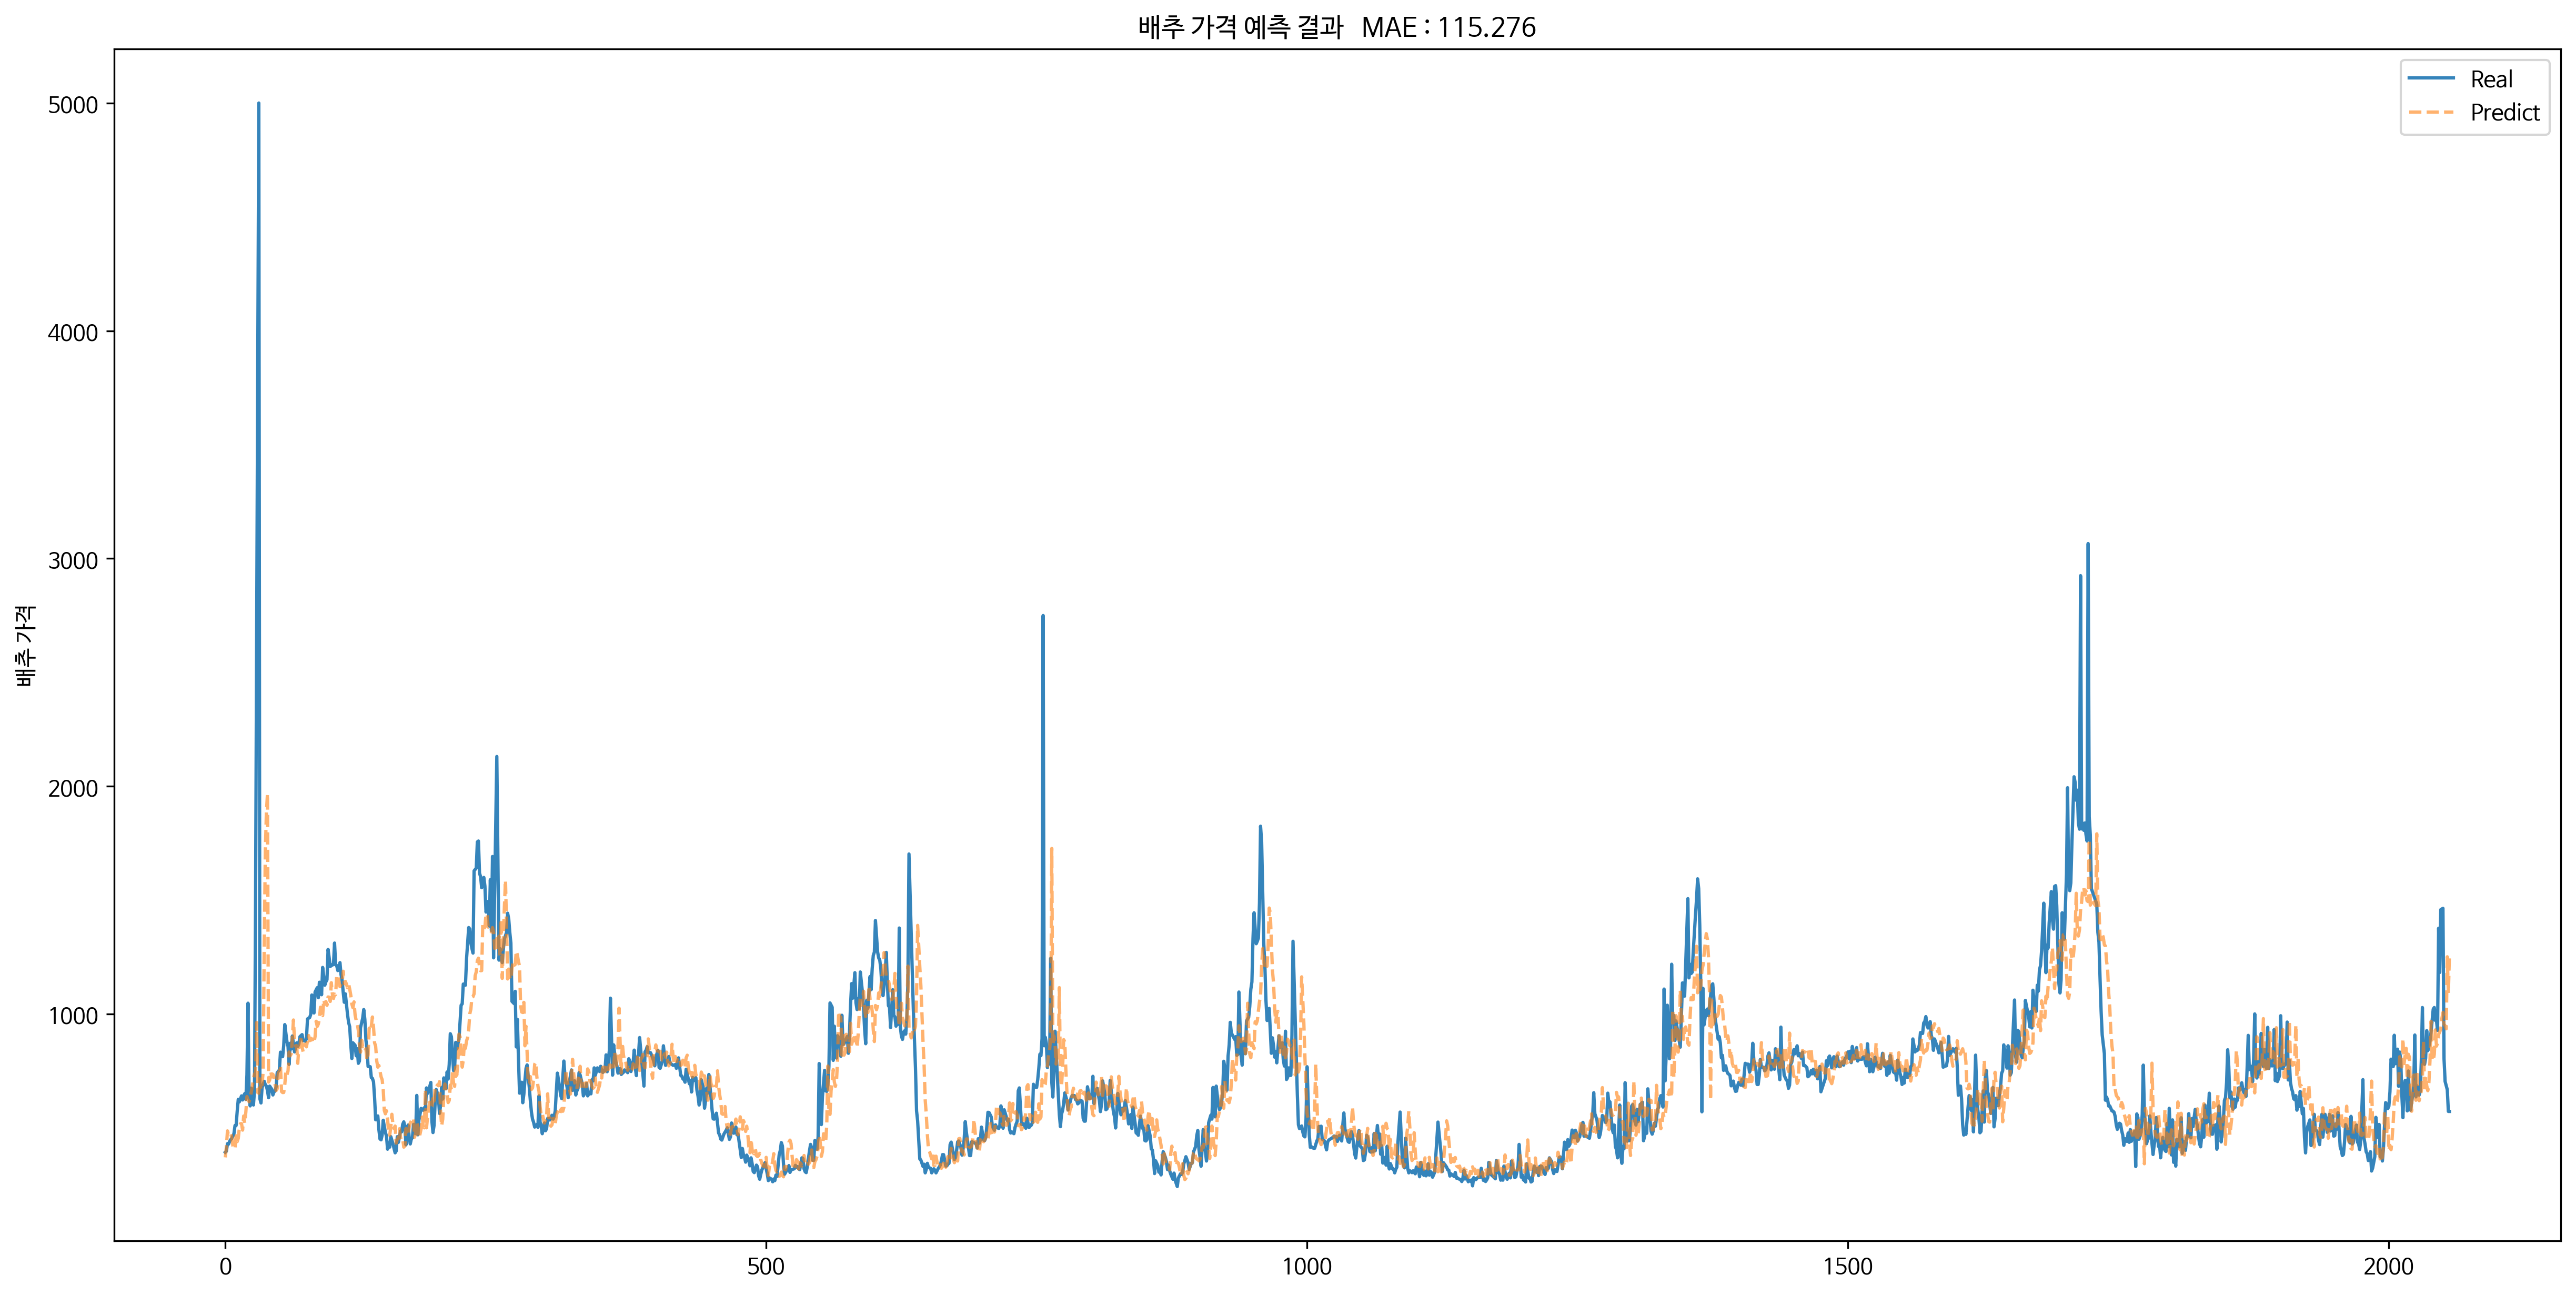

In [ ]:
my_nong1.get_plot()

## 모델 실행

제출일 기준 모든 거래 품목의 1주후, 2주후, 4주후 가격을 예측하는 코드

In [ ]:
weeks = [1,2,4]
features = ['배추', '무', '양파', '건고추', '마늘', '대파', '얼갈이배추', '양배추', '깻잎', '시금치', '미나리', '당근', '파프리카', '새송이', '팽이버섯', 
            '토마토', '청상추', '백다다기', '애호박', '캠벨얼리', '샤인마스캇']

week1=[]
week2=[]
week4=[]

for week in weeks:
  print(week)
  for feature in features:
    my_nong1 = Nong1(df1, df2)
    my_nong1.set_feature(feature)
    my_nong1.set_target(week)
    my_nong1.set_model()
    if week == 1:
      week1.append(my_nong1.get_price())
    if week == 2:
      week2.append(my_nong1.get_price())
    if week == 4:
      week4.append(my_nong1.get_price())
    print(feature)

1


KeyboardInterrupt: ignored

## 데이터프레임 업데이트

제출일 기준 어제의 농산물 가격 데이터를 기존의 데이터프레임과 합치는 코드

매일 매일 업데이트 되는 데이터를 자동으로 업데이트 할 수 있음

In [ ]:
df1

date   요일  ...  샤인마스캇_거래량(kg)  샤인마스캇_가격(원/kg)
0              2016-01-01  금요일  ...            0.0             0.0
1              2016-01-02  토요일  ...            0.0             0.0
2              2016-01-03  일요일  ...            0.0             0.0
3              2016-01-04  월요일  ...            0.0             0.0
4              2016-01-05  화요일  ...            0.0             0.0
...                   ...  ...  ...            ...             ...
2059           2021-09-23  목요일  ...         9194.0         12065.0
2060           2021-09-24  금요일  ...       462828.8         10151.0
2061           2021-09-25  토요일  ...       441083.3          9507.0
2062           2021-09-26  일요일  ...            0.0             0.0
2063  2021-09-27 00:00:00  월요일  ...       437645.6          8801.0

[2064 rows x 44 columns]

In [ ]:
df1 = pd.concat([df1, df2], axis=0)
df1.to_csv('/content/gdrive/MyDrive/nongsan_data/df1.csv', encoding='utf-8-sig', index=False)

In [ ]:
df2

date   요일  배추_거래량(kg)  ...  캠벨얼리_가격(원/kg)  샤인마스캇_거래량(kg)  샤인마스캇_가격(원/kg)
0 2021-09-28  화요일   1645627.9  ...           4442       341639.9            8110

[1 rows x 44 columns]

In [ ]:
df1

date   요일  ...  샤인마스캇_거래량(kg)  샤인마스캇_가격(원/kg)
0              2016-01-01  금요일  ...            0.0             0.0
1              2016-01-02  토요일  ...            0.0             0.0
2              2016-01-03  일요일  ...            0.0             0.0
3              2016-01-04  월요일  ...            0.0             0.0
4              2016-01-05  화요일  ...            0.0             0.0
...                   ...  ...  ...            ...             ...
2060           2021-09-24  금요일  ...       462828.8         10151.0
2061           2021-09-25  토요일  ...       441083.3          9507.0
2062           2021-09-26  일요일  ...            0.0             0.0
2063  2021-09-27 00:00:00  월요일  ...       437645.6          8801.0
0     2021-09-28 00:00:00  화요일  ...       341639.9          8110.0

[2065 rows x 44 columns]

## 고려한 내용 : 참고해서 피피티를 만들기

- EDA : 계절 패턴 특이값(건고추) 이상치가 아니라 우리가 실제로 예측해야 하는 값

- 다양한 시도 : 랜덤포레스트 모델, feature selection

- 창의적 시도 : 시계열 분해 일요일 뺸거

- 효율적인 활용 : 오늘 날짜만 입력하면 바로 1주후 2주후 4주후 예측 가능

- 용이한 유지보수 : 클래스로 만들어서 필요한 부분만 쉽게 수정 가능

- 알고리즘 설명 : 

---

시계열성을 반영하기 위해 LSTM 모델을 

사용했고 과거 21일의 데이터로 미래를 예측하는 모델

오버피팅을 방지하기 위해 dropout 기법을 사용했고 비율은 10%

오버피팅을 방지하기 위해 전체 데이터 중 10%를 validation set으로 이용하여
earlystop 기법을 사용했음

